In [33]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, roc_curve, auc

In [34]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 13

In [35]:
from types import GenericAlias
class LinkPrediction:
    def __init__(self, G):
        self.G = G
    def analyze_network(self):
        print('\n==========Phan tich mang=========\n')
        print(f'So luong node: {self.G.number_of_nodes()}')
        print(f'So luong canh: {self.G.number_of_edges()}')
        print(f'He so clustering: {nx.average_clustering(self.G):.3f}')

        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8)
        plt.title('Cau truc cua mang')

        plt.subplot(132)
        degrees = [d for n, d in self.G.degree()]
        sns.histplot(degrees, kde=True)
        plt.title('Phan phoi bac')

        plt.subplot(133)
        clustering_coef = list(nx.clustering(self.G).values())
        plt.hist(clustering_coef, bins=10,edgecolor='black')
        plt.title('Phan phoi he so clustering')

        plt.tight_layout()
        plt.show()
    
    def prepare_data(self):
        self.all_edges = list(self.G.edges())
        self.all_non_edges = list(nx.non_edges(self.G))
        np.random.shuffle(self.all_non_edges)
        self.all_non_edges = self.all_non_edges[:len(self.all_edges)]

        train_edges, test_edges = train_test_split(self.all_edges, test_size=0.2, random_state=42)
        train_non_edges, test_non_edges = train_test_split(self.all_non_edges, test_size=0.2, random_state=42)

        self.train_edges = train_edges
        self.train_non_edges = train_non_edges
        self.test_edges = test_edges
        self.test_non_edges = test_non_edges
        print('\n==========Thong tin ve du lieu=========\n')
        print(f'So canh traing: {len(self.train_edges)} positive, {len(self.train_non_edges)} negative',)
        print(f'So canh test: {len(self.test_edges)} positive, {len(self.test_non_edges)} negative')
    
    def common_neighbors_score(self, u, v):
        """
        Tính điểm dựa trên số lượng láng giềng chung.
        """
        return len(list(nx.common_neighbors(self.G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """
        Tính hệ số Jaccard.
        """
        neighbors_u = set(self.G.neighbors(u))
        neighbors_v = set(self.G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """
        Tính chỉ số Adamic/Adar.
        """
        return sum(1 / np.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v))

    def extract_features(self, edge_list):
        """
        Trích xuất đặc trưng cho các cạnh.
        """
        features = []
        for u, v in edge_list:
            features.append([
                self.common_neighbors_score(u, v),
                self.jaccard_coefficient_score(u, v),
                self.adamic_adar_score(u, v)
            ])
        return np.array(features)
    def visualize_prediction(self, test_pairs, predictions, title):
        """
        Vẽ đồ thị với các cạnh được dự đoán.
        - Xanh: Cạnh có sẵn trong đồ thị gốc
        - Đỏ: Cạnh được dự đoán là sẽ xuất hiện
        """
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(self.G, seed=42)

        # Vẽ đồ thị gốc
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8, edge_color='green', width=1)

        # Vẽ các cạnh được dự đoán
        predicted_edges = [test_pairs[i] for i in range(len(predictions)) if predictions[i] == 1]
        nx.draw_networkx_edges(self.G, pos, edgelist=predicted_edges,
                            edge_color='red', style='dashed', width=2)

        plt.title(title)
        plt.show()
    
    def evaluate_methods(self):
        """
        Đánh giá các phương pháp dự đoán liên kết.
        """
        print("\n=== Đánh giá các phương pháp ===")
        # Chuẩn bị dữ liệu train
        X_train = self.extract_features(self.train_edges + self.train_non_edges)
        y_train = np.hstack([np.ones(len(self.train_edges)),
                            np.zeros(len(self.train_non_edges))])

        # Chuẩn bị dữ liệu test
        X_test = self.extract_features(self.test_edges + self.test_non_edges)
        y_test = np.hstack([np.ones(len(self.test_edges)),
                        np.zeros(len(self.test_non_edges))])

        test_pairs = self.test_edges + self.test_non_edges
        methods = ['Common Neighbors','Jaccard Coefficient','Adamic/Adar']
        results = []

        for i in range(3):
            # Tính ngưỡng từ tập train
            threshold = np.mean(X_train[:, i])

            # Dự đoán trên tập test
            predictions = (X_test[:, i] > threshold).astype(int)

            # Tính các metrics
            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': methods[i],
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            # Vẽ kết quả dự đoán cho mỗi phương pháp
            self.visualize_prediction(test_pairs, predictions,
                                    f'Dự đoán liên kết bằng {methods[i]}')
        df_results = pd.DataFrame(results)
        plt.figure(figsize=(10, 3))
        plt.axis('off')
        table = plt.table(cellText=df_results.values,
                        colLabels=df_results.columns,
                        loc='center',
                        cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Bảng đánh giá các phương pháp')
        plt.show()

    def run_experiment(self):
        print('\n==========Bat dau thuc nghiem=========\n')
        self.analyze_network()
        self.prepare_data()
        self.evaluate_methods()


==========Bat dau thuc nghiem=========


==========Phan tich mang=========

So luong node: 34
So luong canh: 78
He so clustering: 0.571


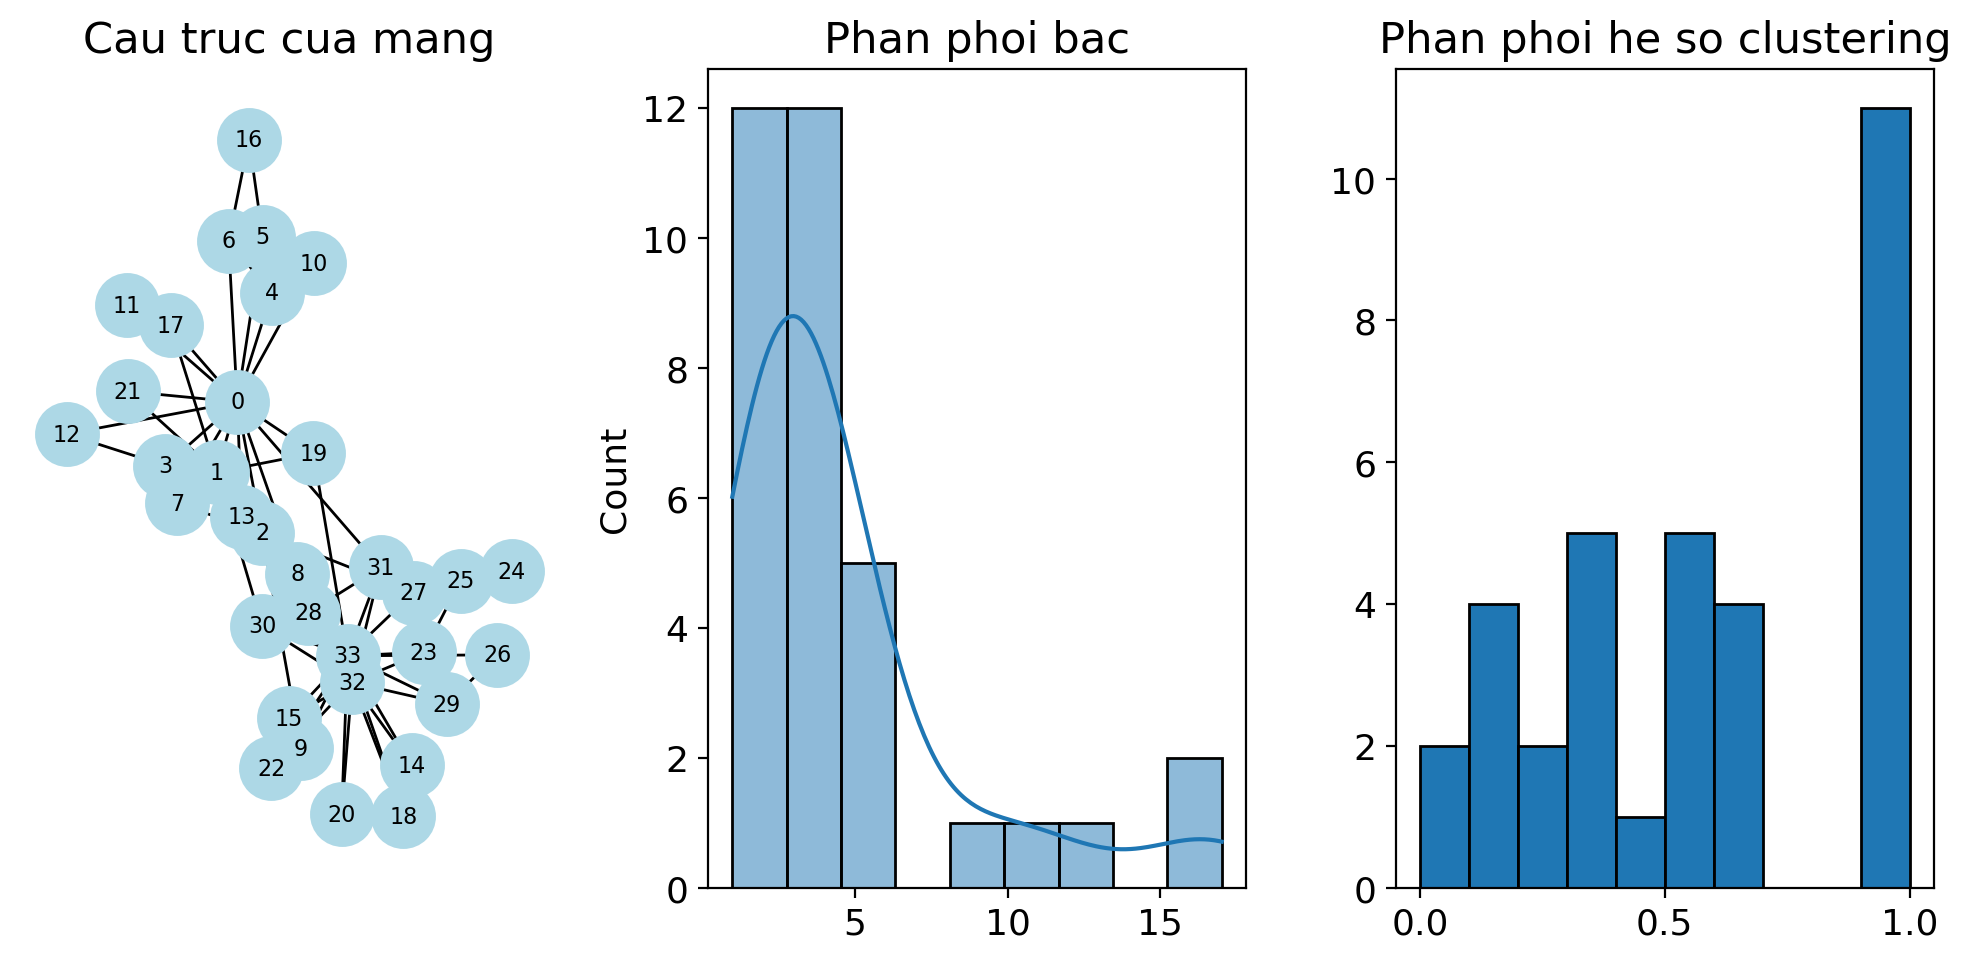


==========Thong tin ve du lieu=========

So canh traing: 62 positive, 62 negative
So canh test: 16 positive, 16 negative

=== Đánh giá các phương pháp ===


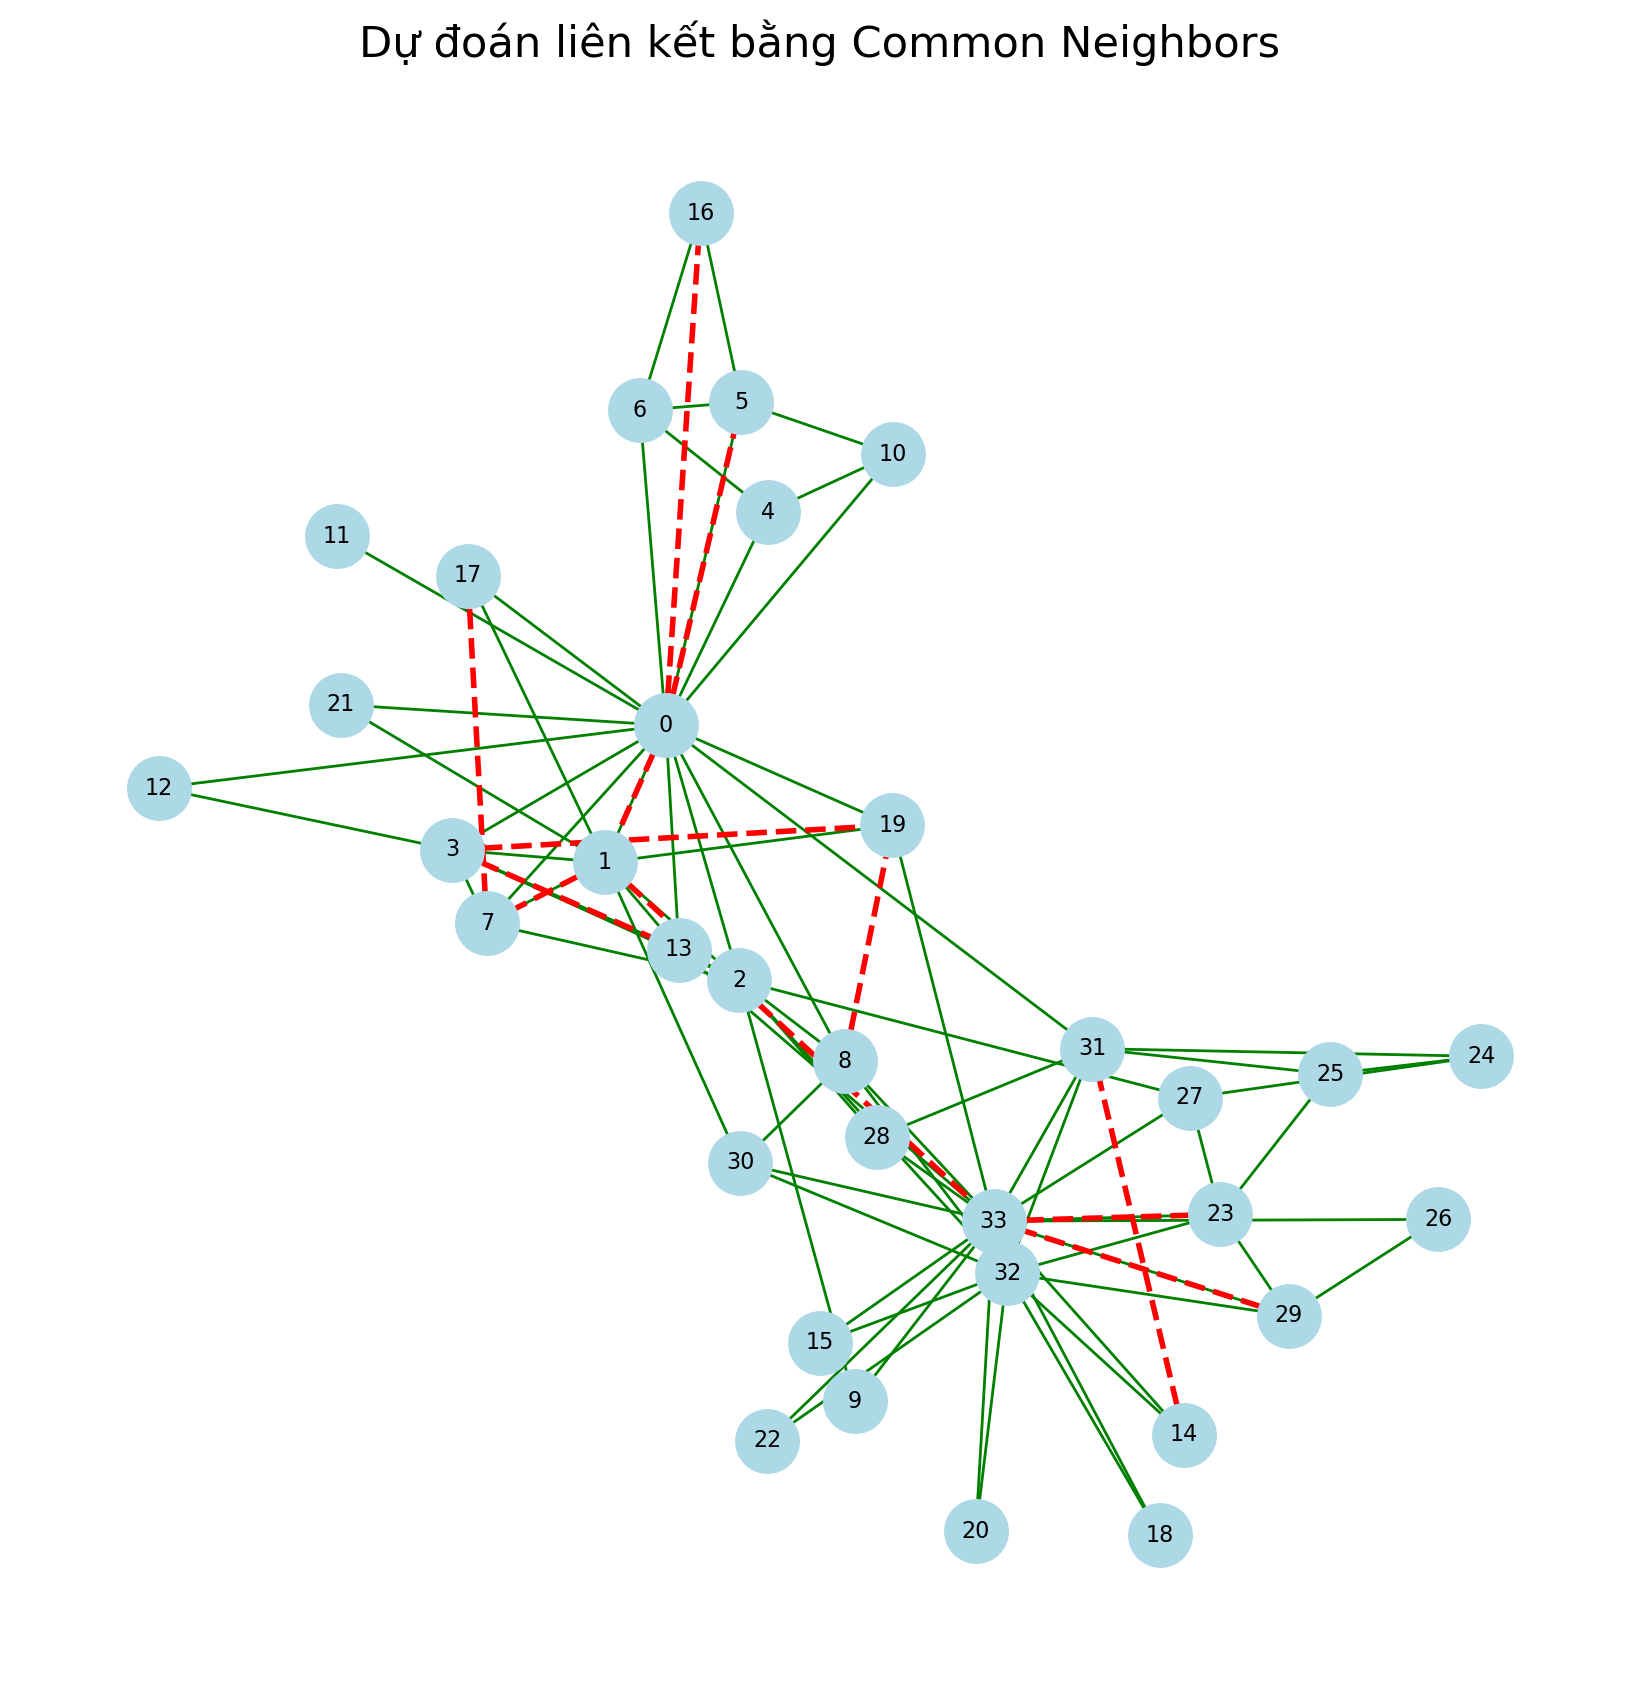

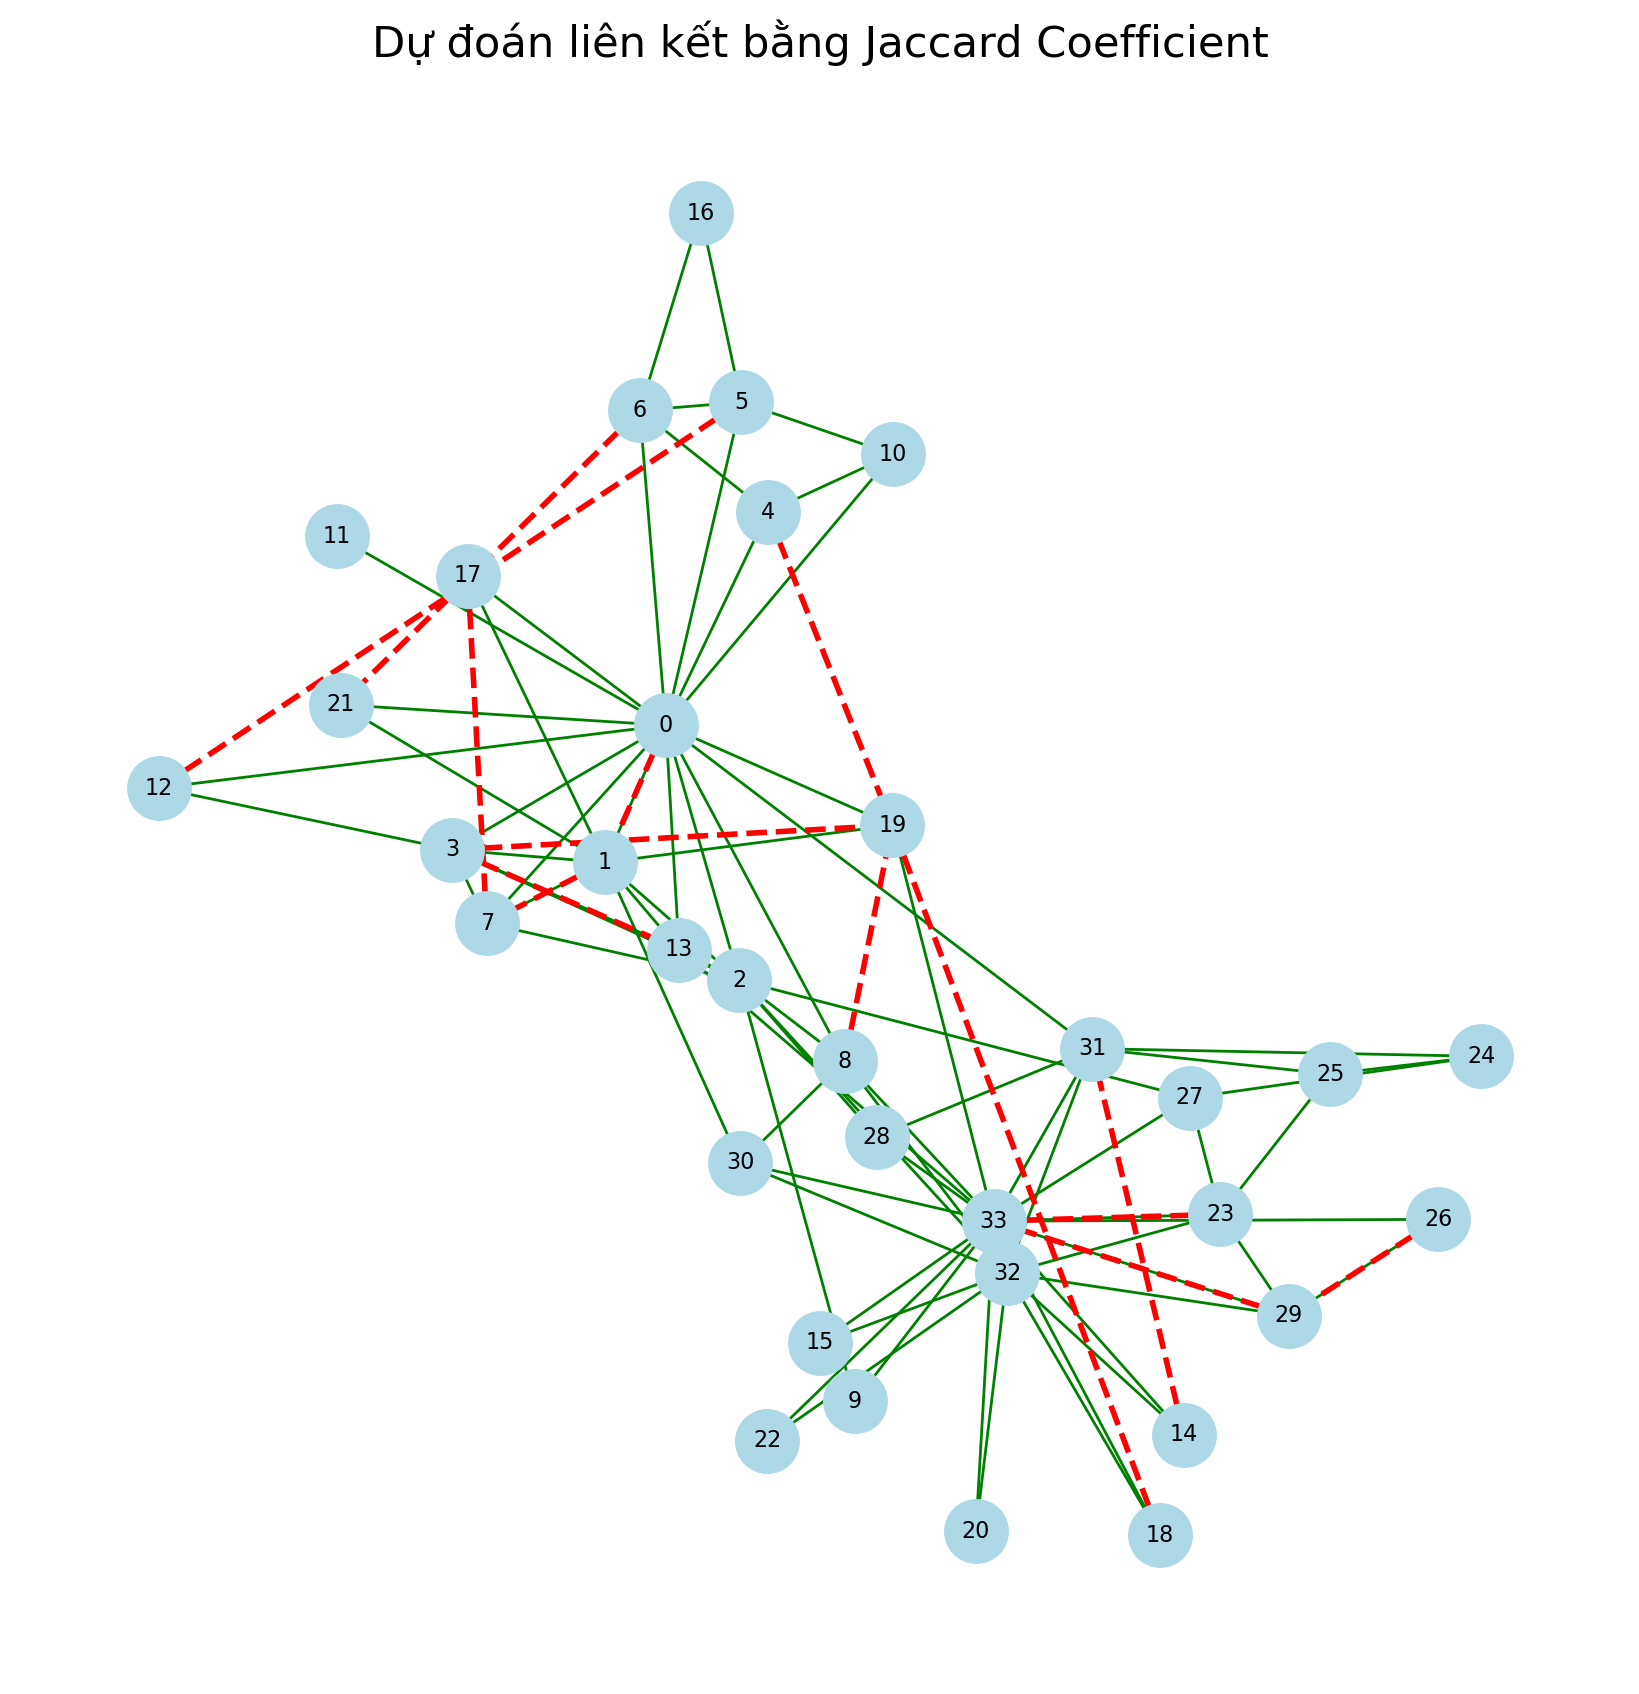

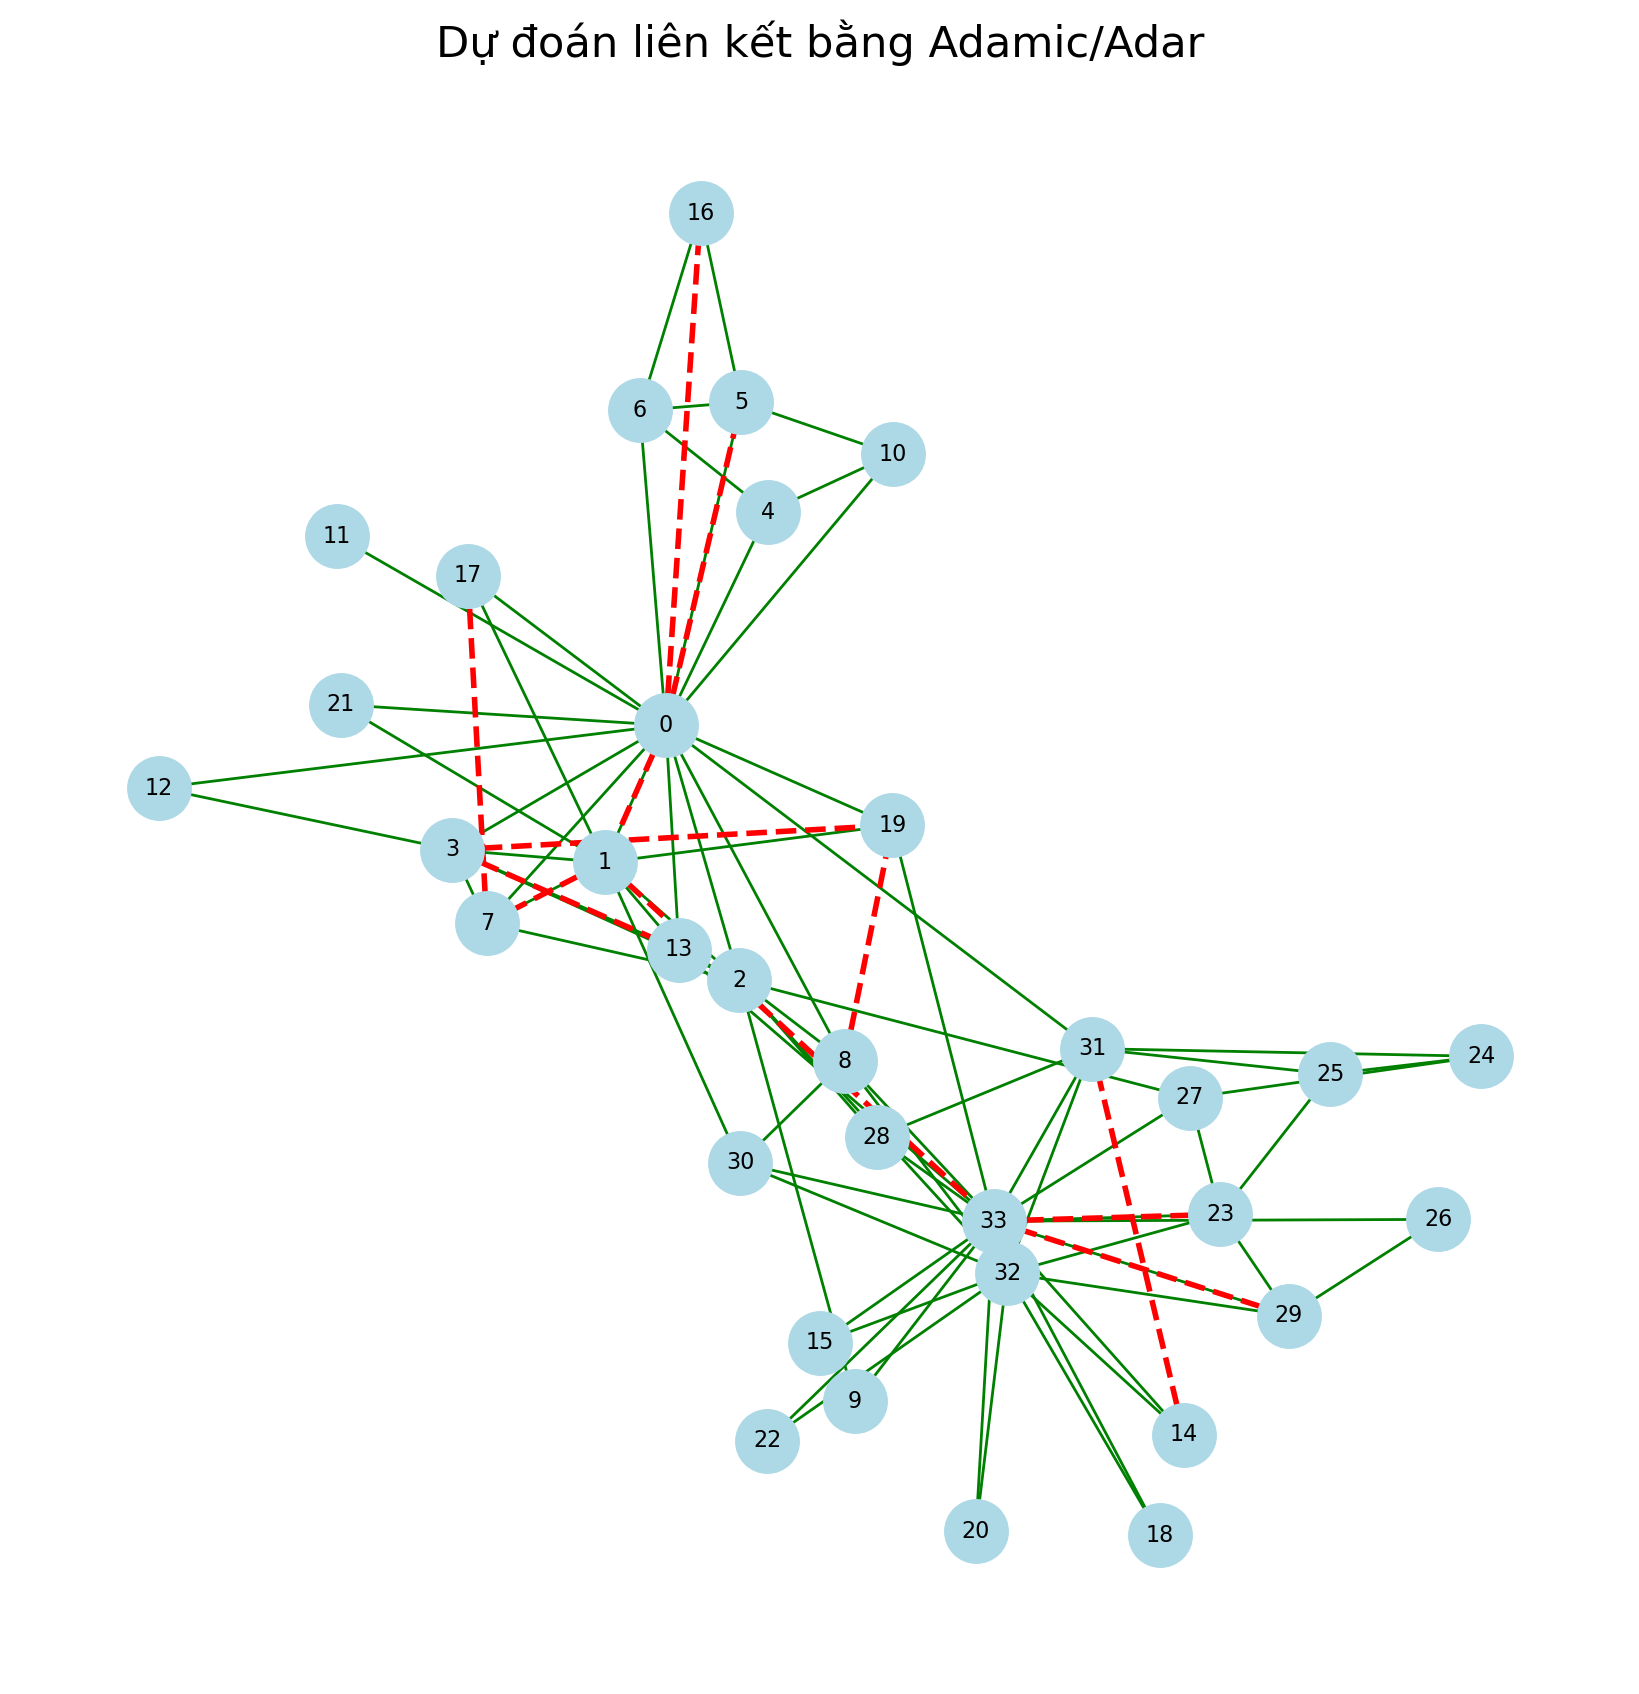

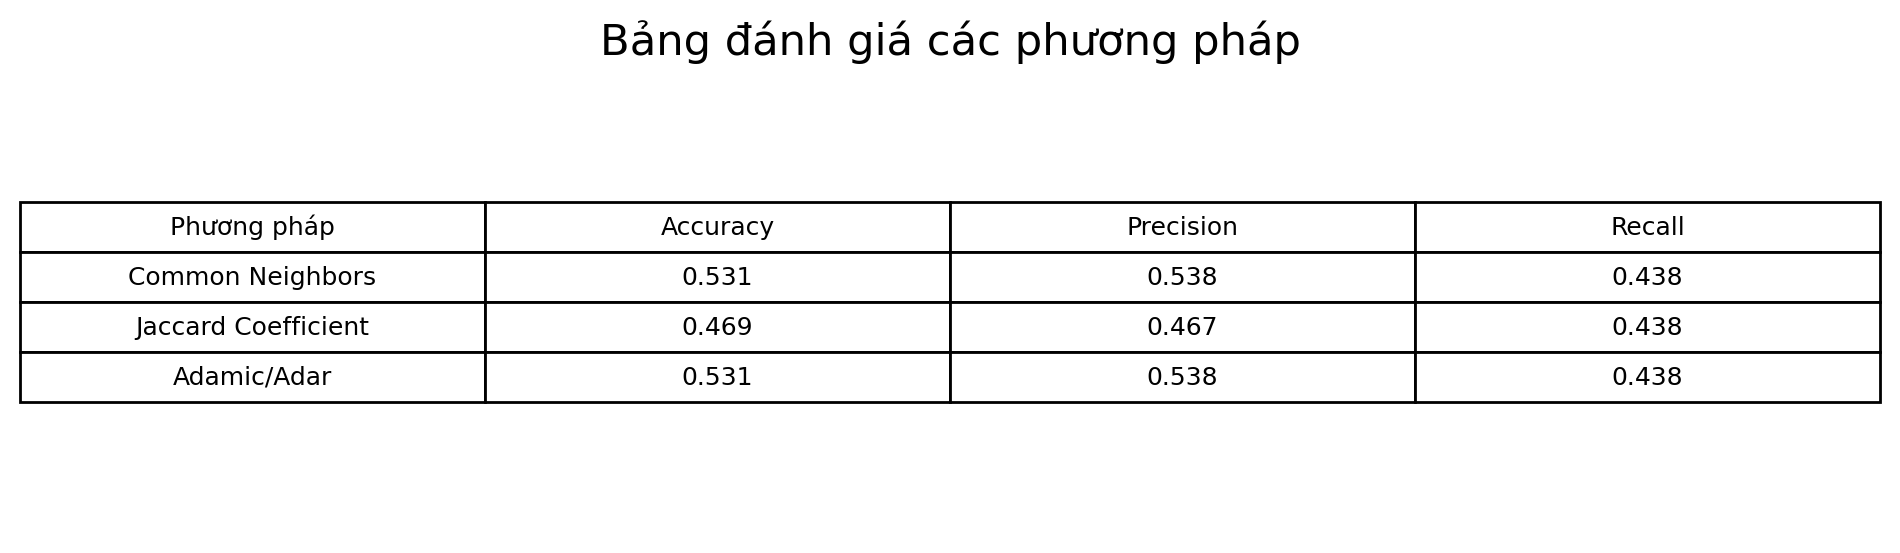

In [36]:
G = nx.karate_club_graph()
lp = LinkPrediction(G)
lp.run_experiment()

## Cau 2

In [37]:
class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với lựa chọn dataset.

        Parameters:
            dataset (str): Tên dataset ('karate', 'davis', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'davis':
            self.G = nx.davis_southern_women_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số lượng node: {self.G.number_of_nodes()}")
        print(f"Số lượng cạnh: {self.G.number_of_edges()}")
        print(f"Hệ số clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))

        # Vẽ cấu trúc mạng ban đầu
        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8)
        plt.title("Cấu trúc mạng ban đầu")

        # Vẽ phân phối bậc
        plt.subplot(132)
        degrees = [d for n, d in self.G.degree()]
        plt.hist(degrees, bins=max(degrees)-min(degrees)+1, edgecolor='black')
        plt.title("Phân phối bậc")
        plt.xlabel("Bậc")
        plt.ylabel("Số lượng node")

        # Vẽ phân phối hệ số clustering
        plt.subplot(133)
        clustering_coeffs = list(nx.clustering(self.G).values())
        plt.hist(clustering_coeffs, bins=10, edgecolor='black')
        plt.title("Phân phối hệ số clustering")
        plt.xlabel("Hệ số clustering")
        plt.ylabel("Số lượng node")

        plt.tight_layout()
        plt.show()

    def prepare_data(self):
        """
        Chuẩn bị dữ liệu bằng cách giả lập dự đoán tương lai:
        1. Ẩn 20% cạnh hiện có (tập test) - giả sử đây là các liên kết sẽ xuất hiện trong tương lai
        2. Sử dụng 80% cạnh còn lại (tập train) để học và dự đoán
        """
        # Copy đồ thị gốc để giữ lại thông tin đầy đủ
        self.original_G = self.G.copy()

        # 1. Chia cạnh thành train/test
        all_edges = list(self.G.edges())
        train_edges, test_edges = train_test_split(all_edges, test_size=0.2, random_state=42)

        # 2. Tạo đồ thị train bằng cách xóa các cạnh test
        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(test_edges)

        # 3. Lấy các cặp node không có cạnh từ đồ thị train
        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        test_non_edges = non_edges[:len(test_edges)]

        # Lưu lại để sử dụng
        self.train_edges = train_edges
        self.test_edges = test_edges        # Các cạnh thật sự sẽ xuất hiện
        self.test_non_edges = test_non_edges  # Các cạnh thật sự không xuất hiện

        print("\n=== Thông tin về tập dữ liệu ===")
        print(f"Tổng số cạnh ban đầu: {len(all_edges)}")
        print(f"Số cạnh train: {len(train_edges)}")
        print(f"Số cạnh test (cạnh sẽ xuất hiện): {len(test_edges)}")
        print(f"Số cặp node test không có cạnh: {len(test_non_edges)}")

        # Vẽ đồ thị train và test
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(self.original_G, seed=42)

        plt.subplot(121)
        nx.draw(self.train_G, pos, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=500, font_size=8)
        plt.title("Đồ thị train\n(80% cạnh)")

        plt.subplot(122)
        nx.draw(self.train_G, pos, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=500, font_size=8)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=test_edges,
                             edge_color='red', style='dashed')
        plt.title("Đồ thị test\nXanh: Train, Đỏ: Cạnh cần dự đoán")

        plt.tight_layout()
        plt.show()

    def common_neighbors_score(self, u, v):
        """Tính điểm dựa trên số lượng láng giềng chung."""
        return len(list(nx.common_neighbors(self.train_G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """Tính hệ số Jaccard."""
        neighbors_u = set(self.train_G.neighbors(u))
        neighbors_v = set(self.train_G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """Tính chỉ số Adamic/Adar."""
        return sum(1 / np.log(self.train_G.degree(w))
                  for w in nx.common_neighbors(self.train_G, u, v))

    def extract_features(self, edge_list):
        """Trích xuất đặc trưng cho các cạnh."""
        features = []
        for u, v in edge_list:
            features.append([
                self.common_neighbors_score(u, v),
                self.jaccard_coefficient_score(u, v),
                self.adamic_adar_score(u, v)
            ])
        return np.array(features)

    def visualize_prediction_validation(self, predictions, method_name):
        """
        Vẽ đồ thị để so sánh dự đoán với thực tế:
        - Xanh: Cạnh trong tập train
        - Đỏ: Cạnh dự đoán đúng (có trong test)
        - Vàng: Cạnh dự đoán sai (không có trong test)
        """
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(self.original_G, seed=42)

        # Đồ thị 1: Dự đoán
        plt.subplot(121)
        # Vẽ cạnh train
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)

        # Vẽ cạnh dự đoán đúng và sai
        test_pairs = self.test_edges + self.test_non_edges
        predicted_edges = [test_pairs[i] for i in range(len(predictions))
                         if predictions[i] == 1]

        correct_edges = [e for e in predicted_edges if e in self.test_edges]
        wrong_edges = [e for e in predicted_edges if e not in self.test_edges]

        nx.draw_networkx_edges(self.train_G, pos, edgelist=correct_edges,
                             edge_color='red', style='dashed', width=2)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=wrong_edges,
                             edge_color='yellow', style='dashed', width=2)
        plt.title(f"{method_name}\nXanh: Train, Đỏ: Dự đoán đúng, Vàng: Dự đoán sai")

        # Đồ thị 2: Thực tế
        plt.subplot(122)
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=self.test_edges,
                             edge_color='red', style='dashed', width=2)
        plt.title("Thực tế\nXanh: Train, Đỏ: Test")

        plt.tight_layout()
        plt.show()

    def evaluate_methods(self):
        """Đánh giá các phương pháp dự đoán liên kết."""
        print("\n=== Đánh giá các phương pháp ===")

        # Chuẩn bị dữ liệu test
        X_test = self.extract_features(self.test_edges + self.test_non_edges)
        y_test = np.hstack([np.ones(len(self.test_edges)),
                           np.zeros(len(self.test_non_edges))])

        # Đánh giá từng phương pháp
        methods = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic/Adar']
        results = []

        for i in range(3):
            # Tính ngưỡng (có thể điều chỉnh)
            scores = X_test[:, i]
            threshold = np.percentile(scores, 70)  # Lấy ngưỡng 70%

            # Dự đoán
            predictions = (scores > threshold).astype(int)

            # Tính các metrics
            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': methods[i],
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            # Vẽ kết quả dự đoán
            self.visualize_prediction_validation(predictions, methods[i])

        # Vẽ bảng kết quả
        df_results = pd.DataFrame(results)
        plt.figure(figsize=(10, 3))
        plt.axis('off')
        table = plt.table(cellText=df_results.values,
                         colLabels=df_results.columns,
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Bảng đánh giá các phương pháp')
        plt.show()

    def run_experiment(self):
        """Chạy toàn bộ thử nghiệm."""
        print("=== Bắt đầu thử nghiệm ===")
        self.analyze_network()
        self.prepare_data()
        self.evaluate_methods()


Chọn dataset:
1. Zachary's Karate Club
4. Les Miserables Network
=== Bắt đầu thử nghiệm ===

=== Phân tích mạng ===
Số lượng node: 32
Số lượng cạnh: 89
Hệ số clustering trung bình: 0.000


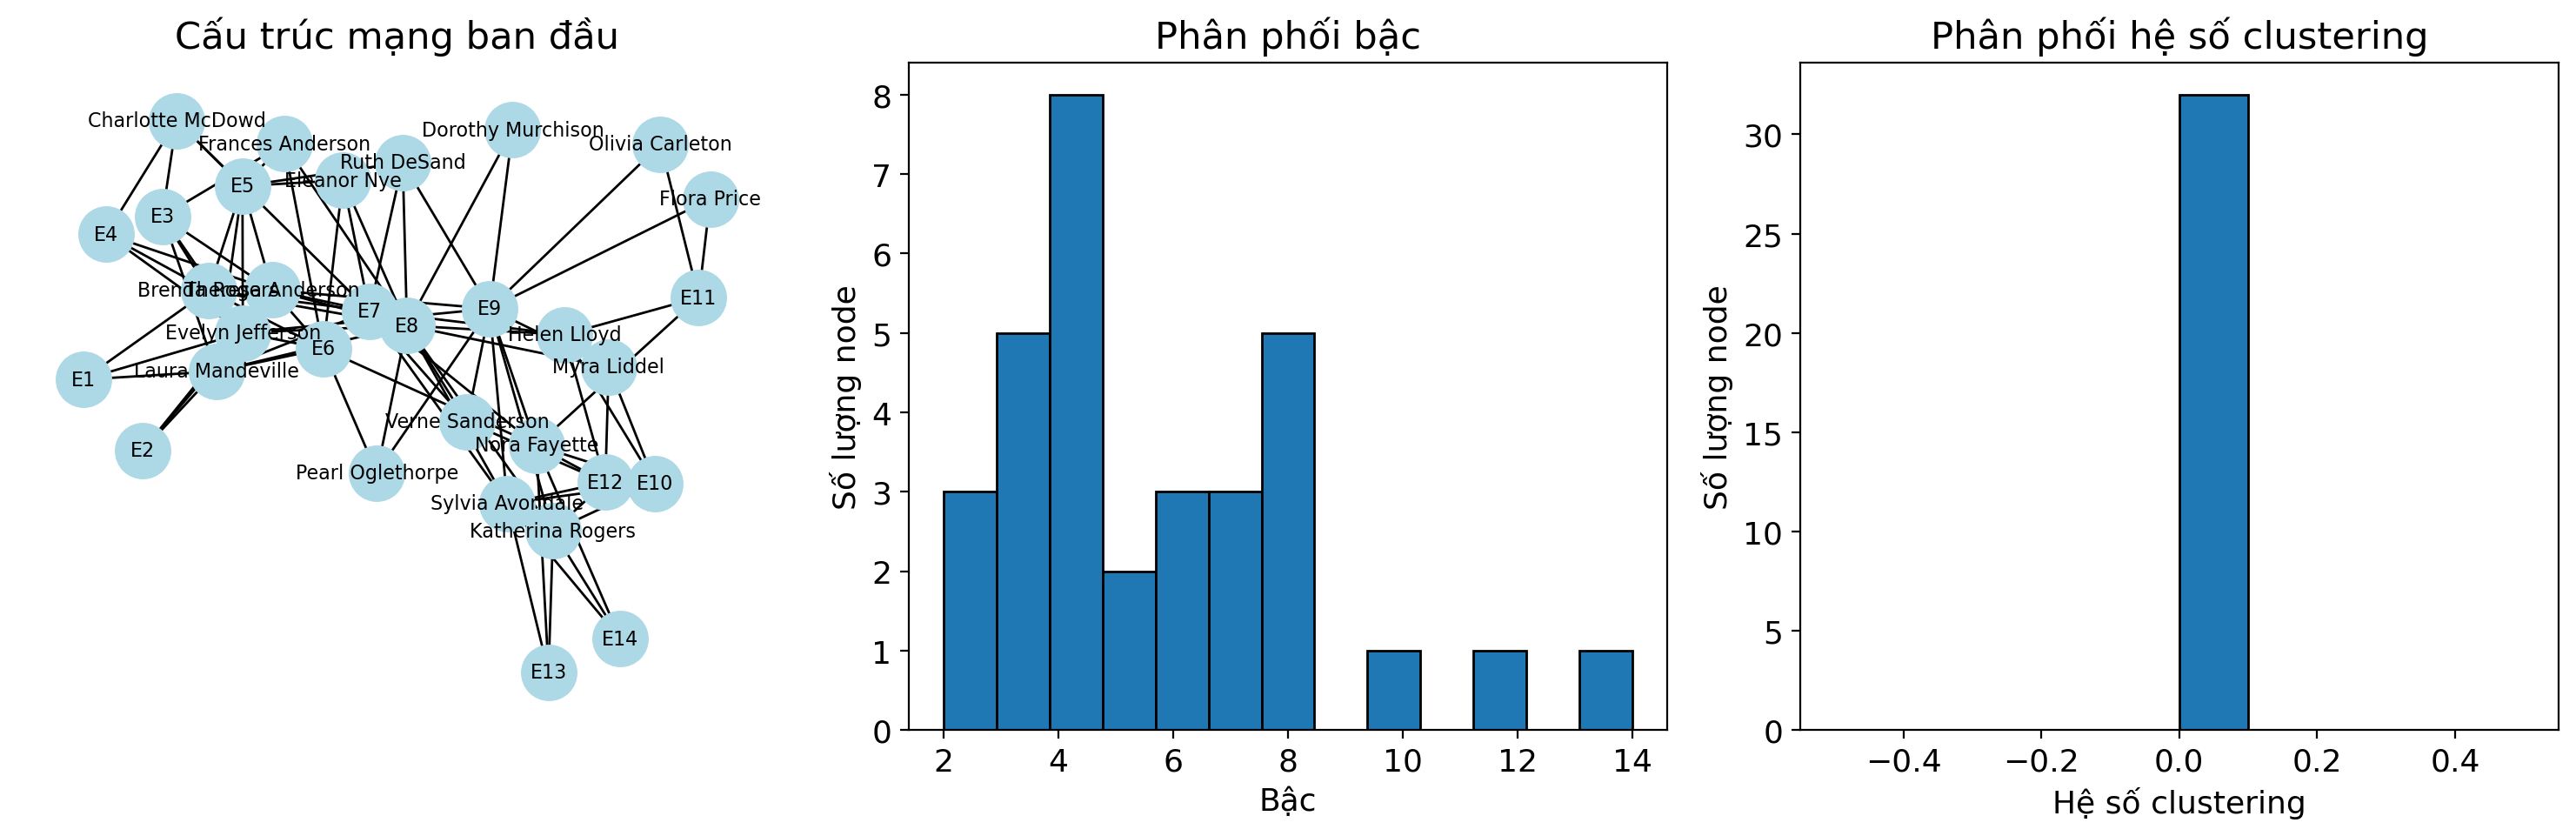


=== Thông tin về tập dữ liệu ===
Tổng số cạnh ban đầu: 89
Số cạnh train: 71
Số cạnh test (cạnh sẽ xuất hiện): 18
Số cặp node test không có cạnh: 18


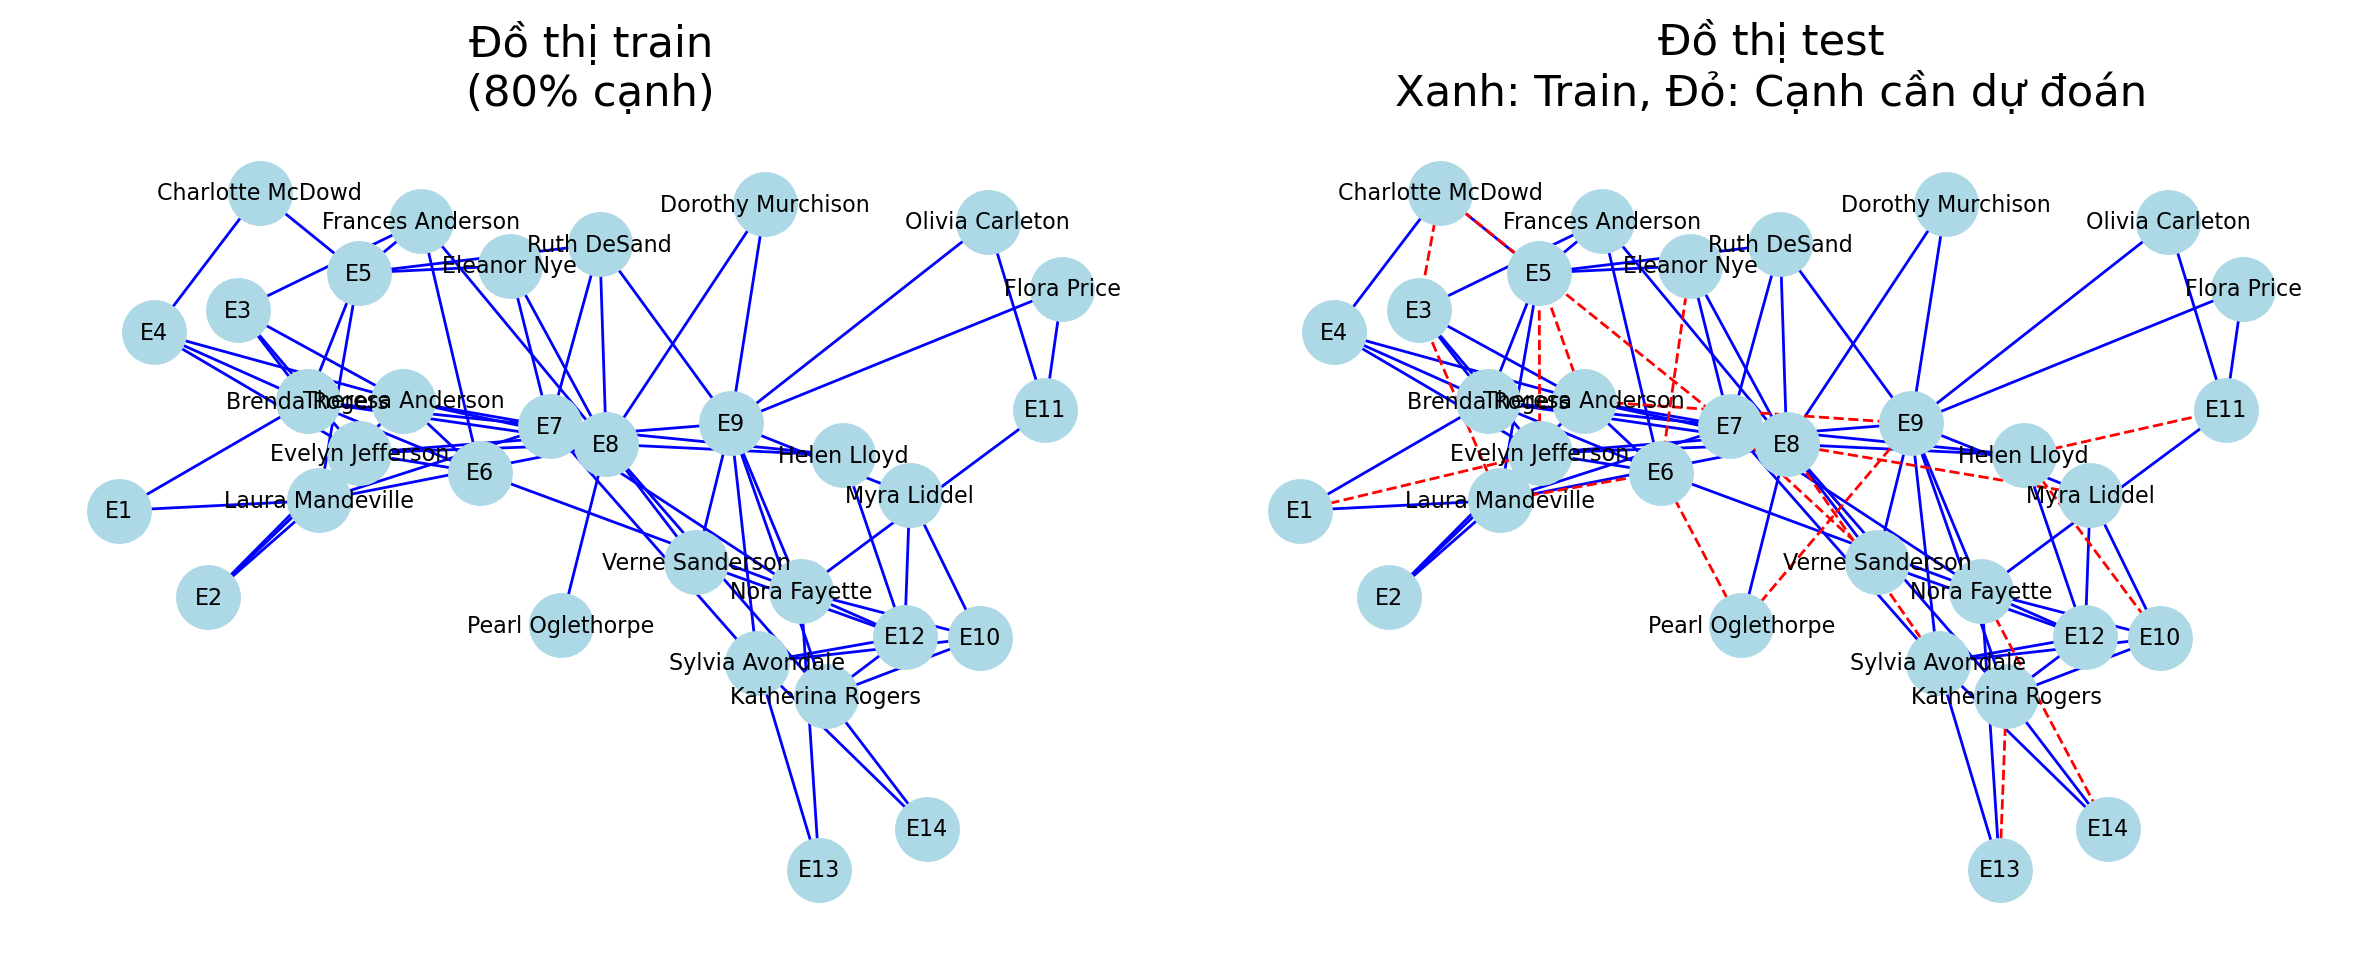


=== Đánh giá các phương pháp ===


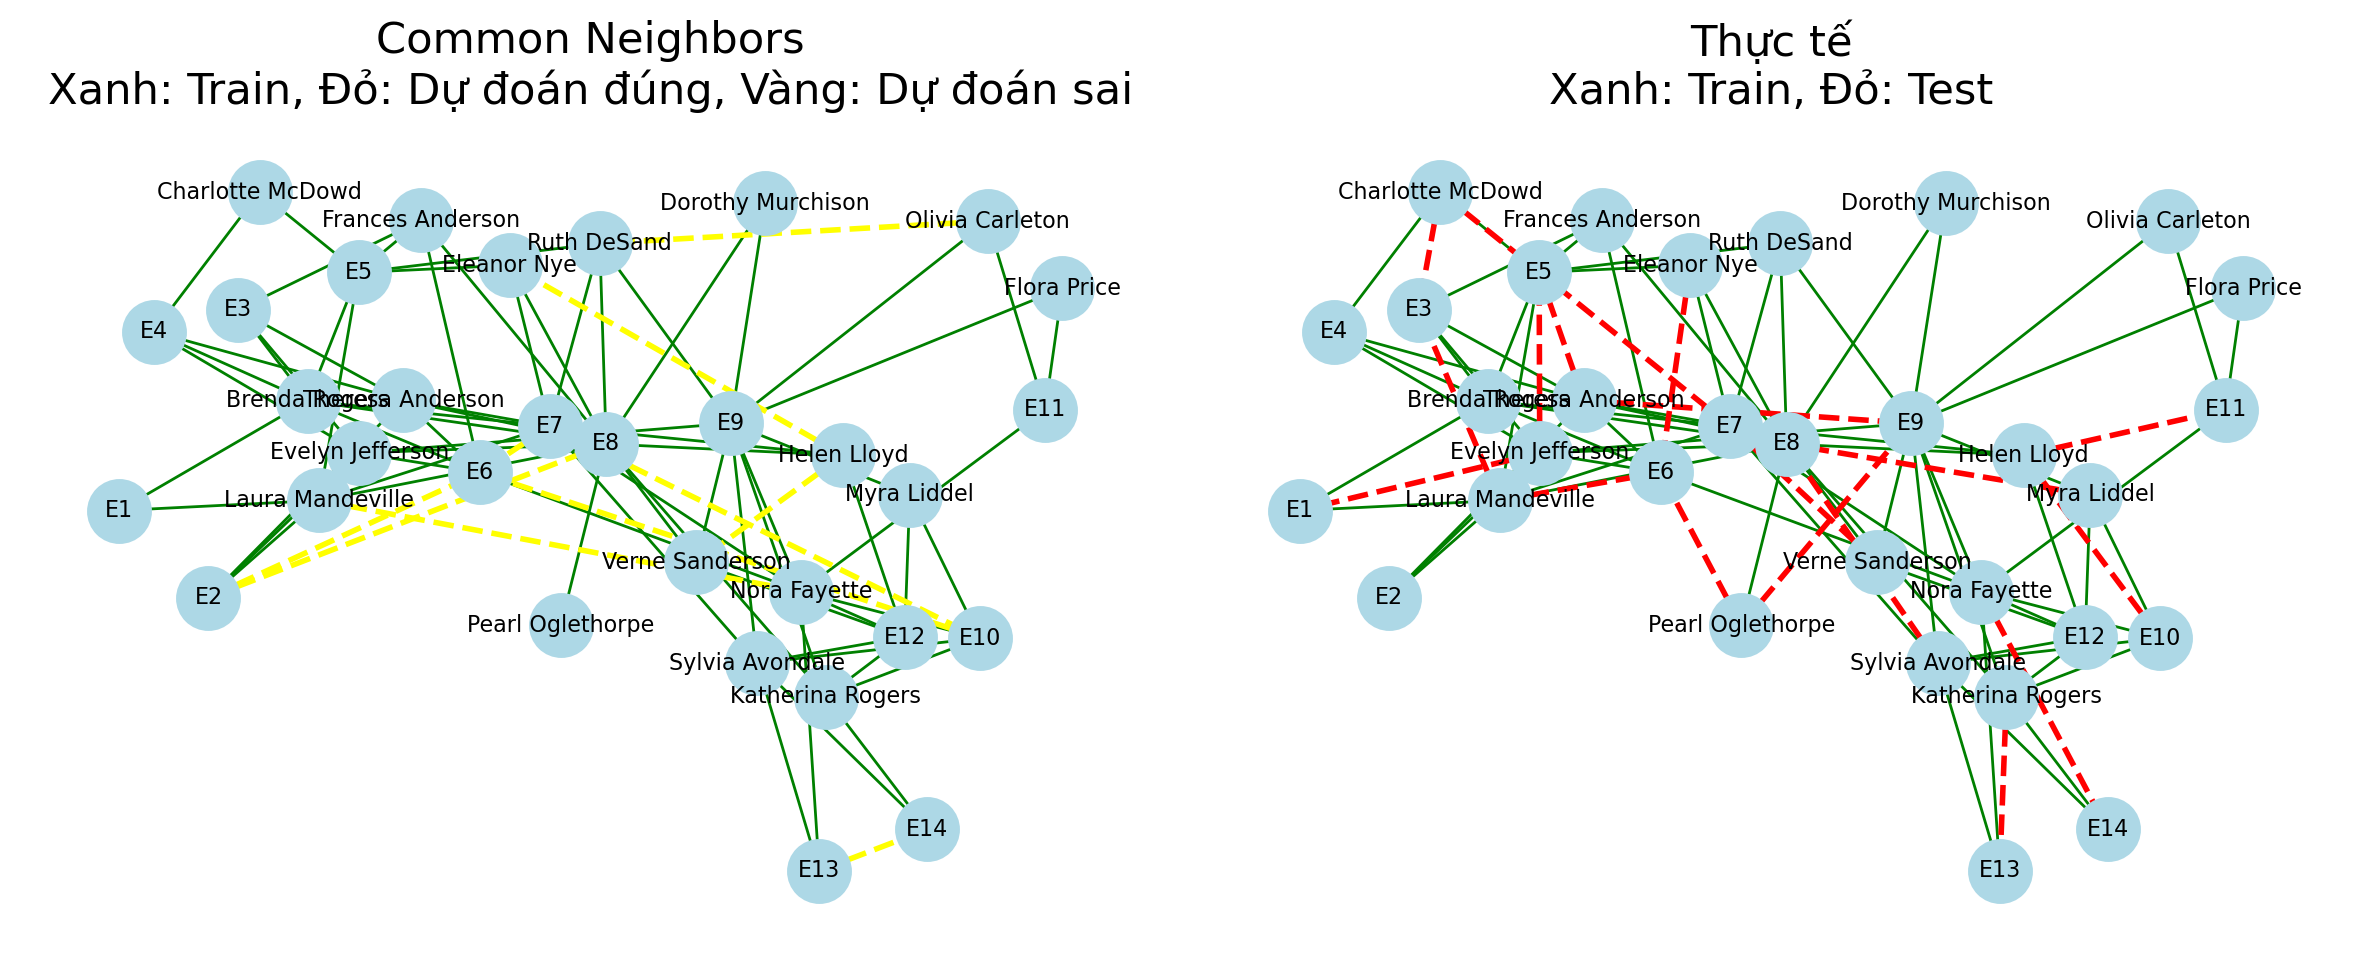

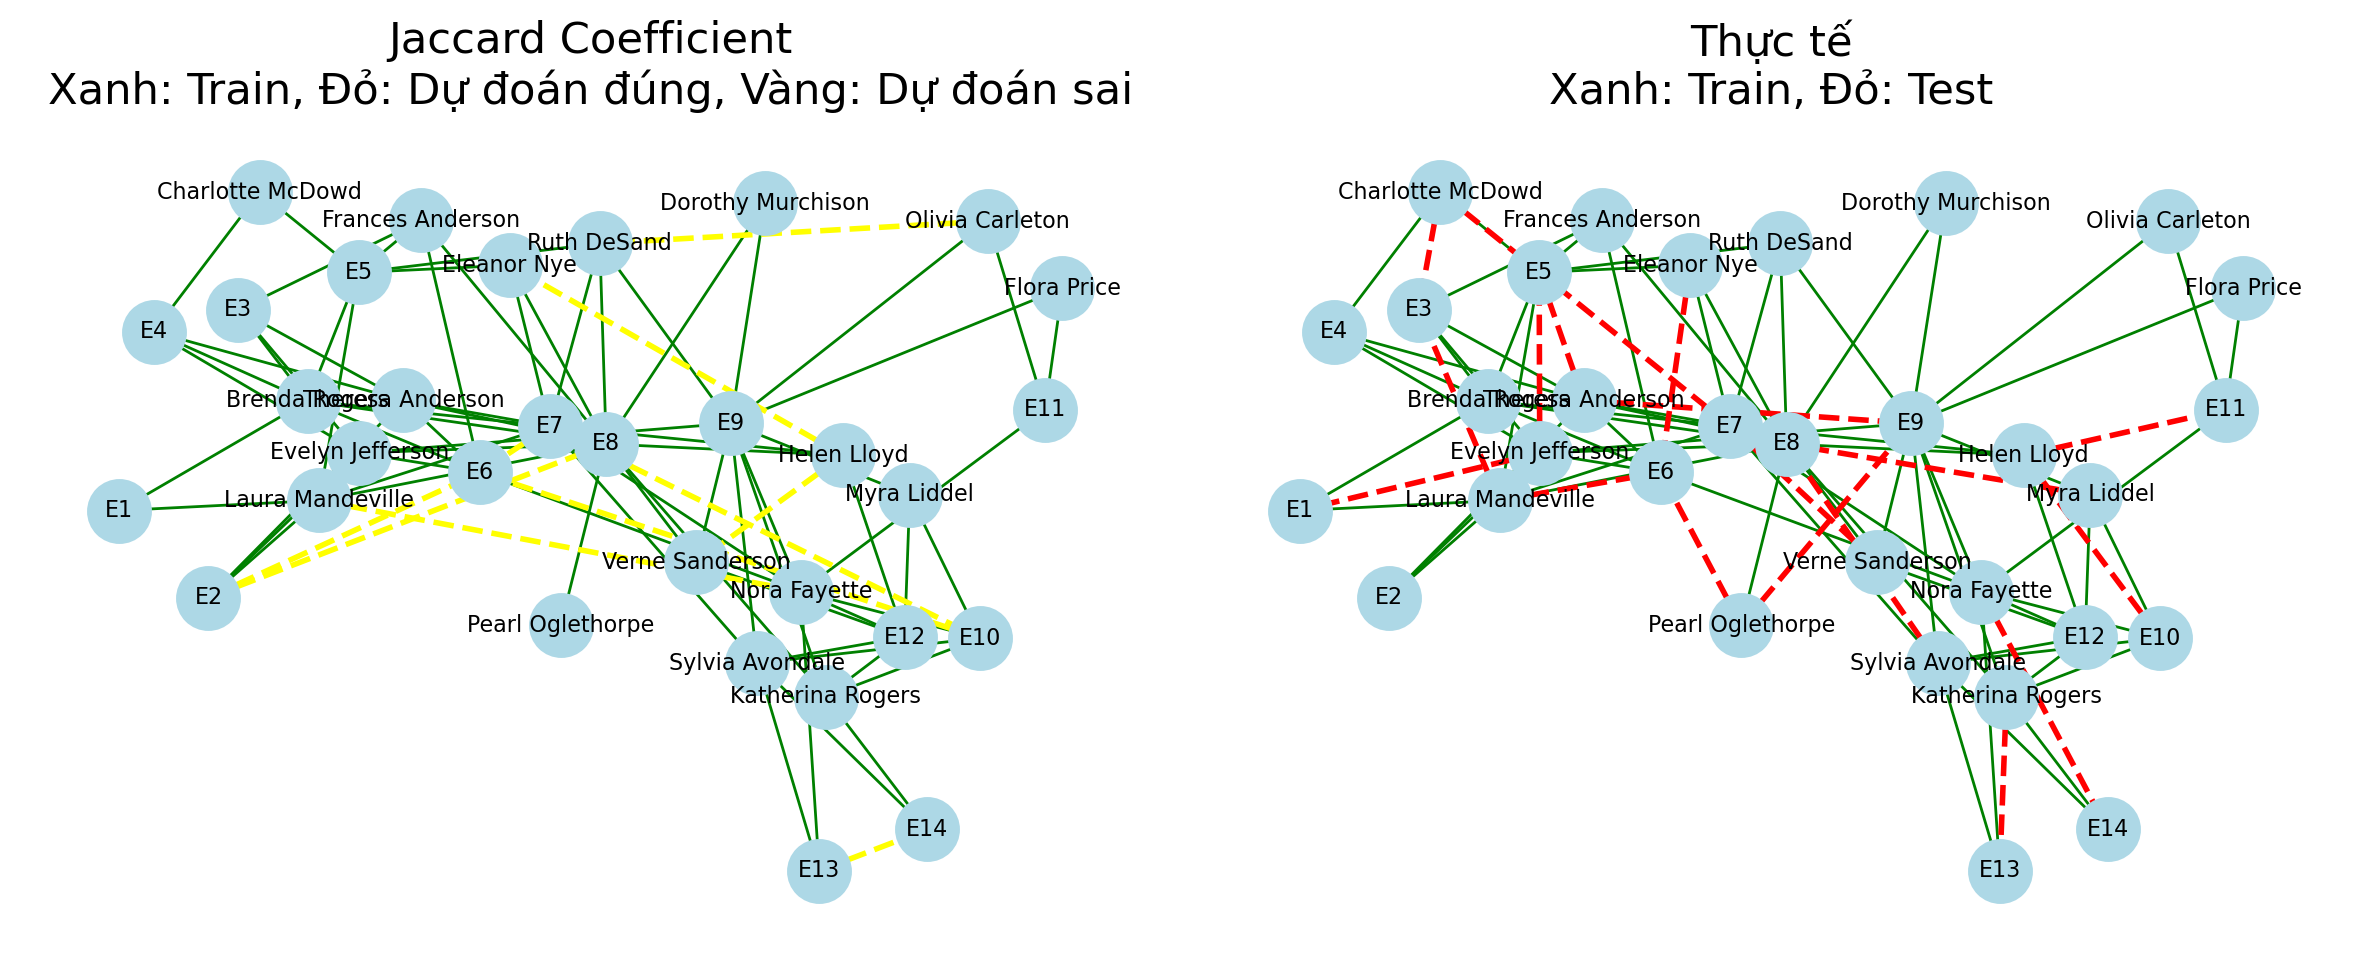

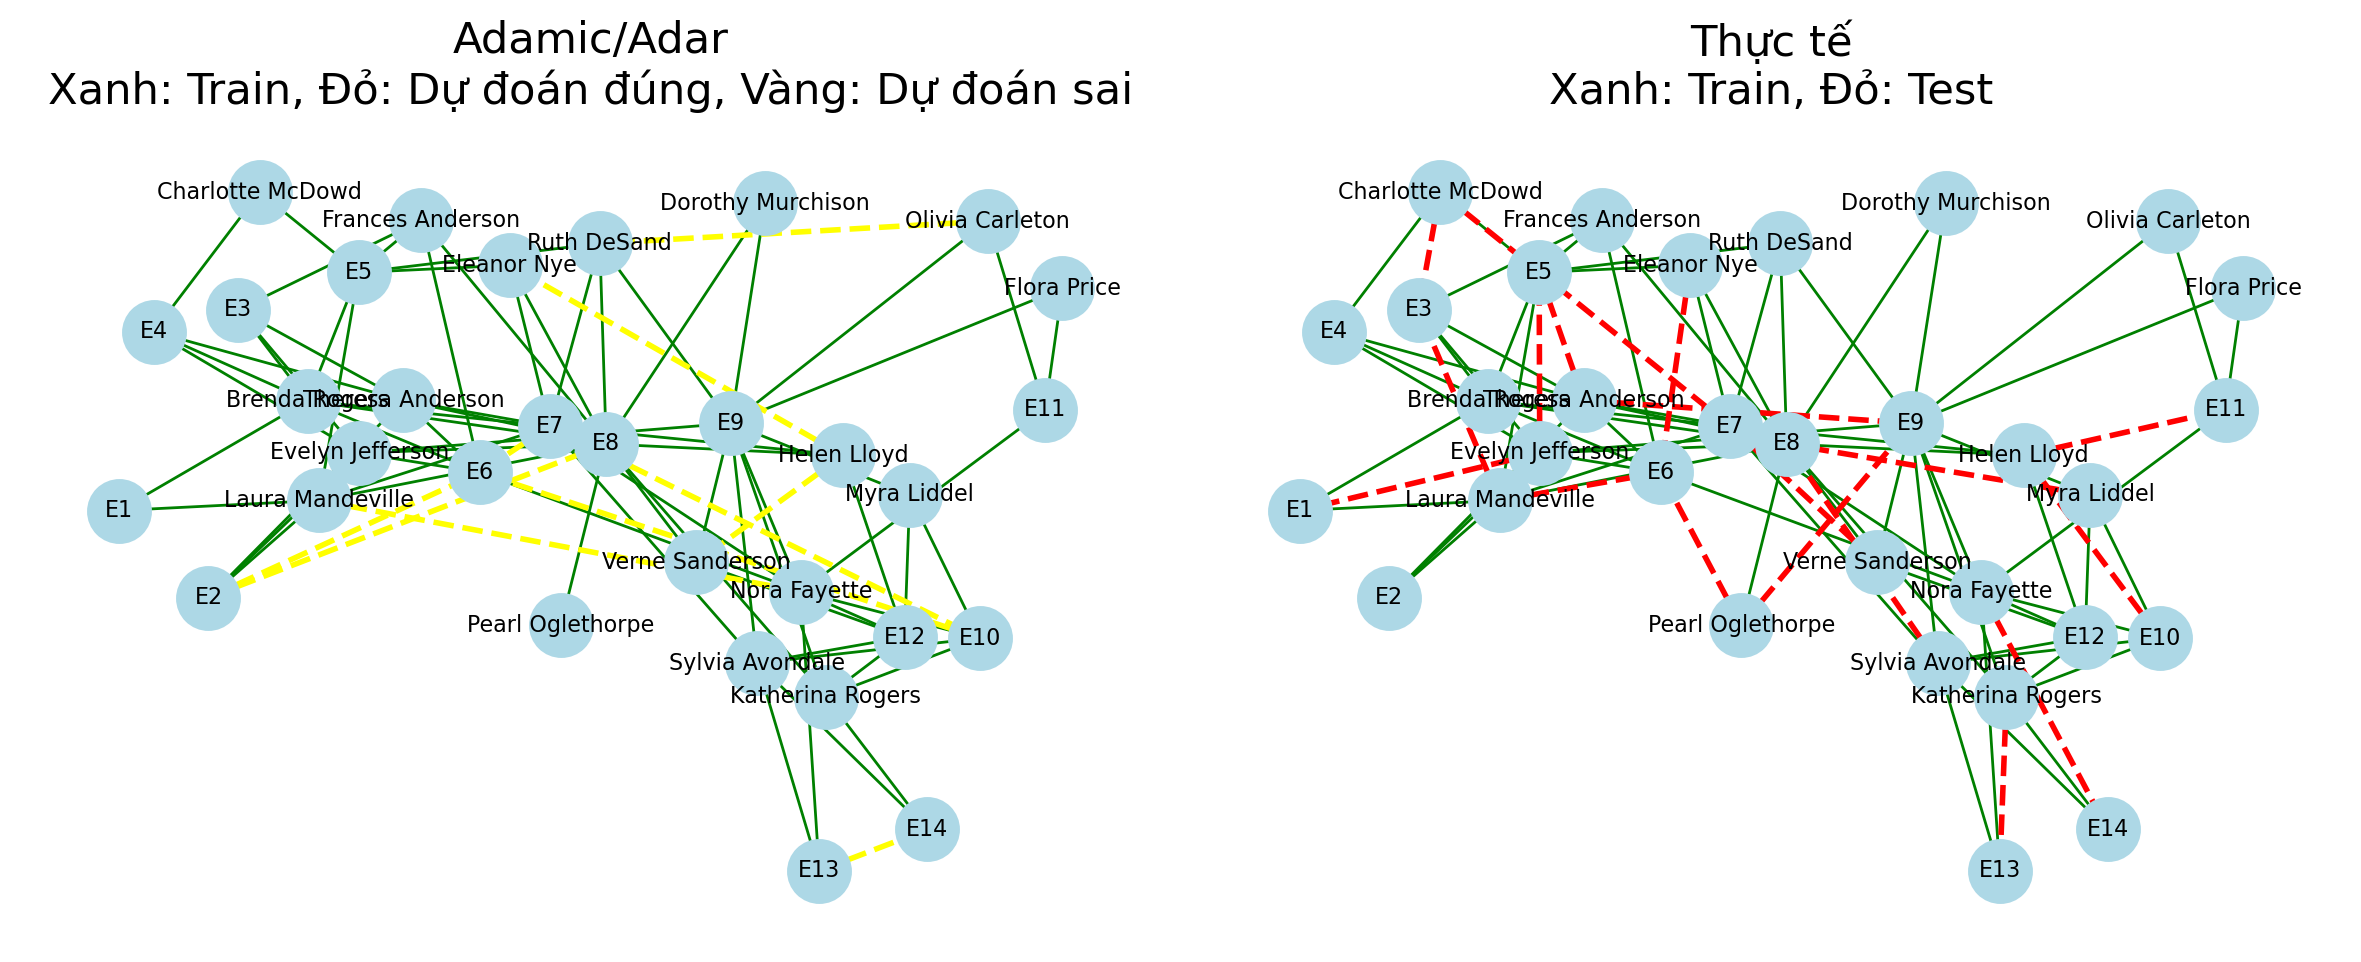

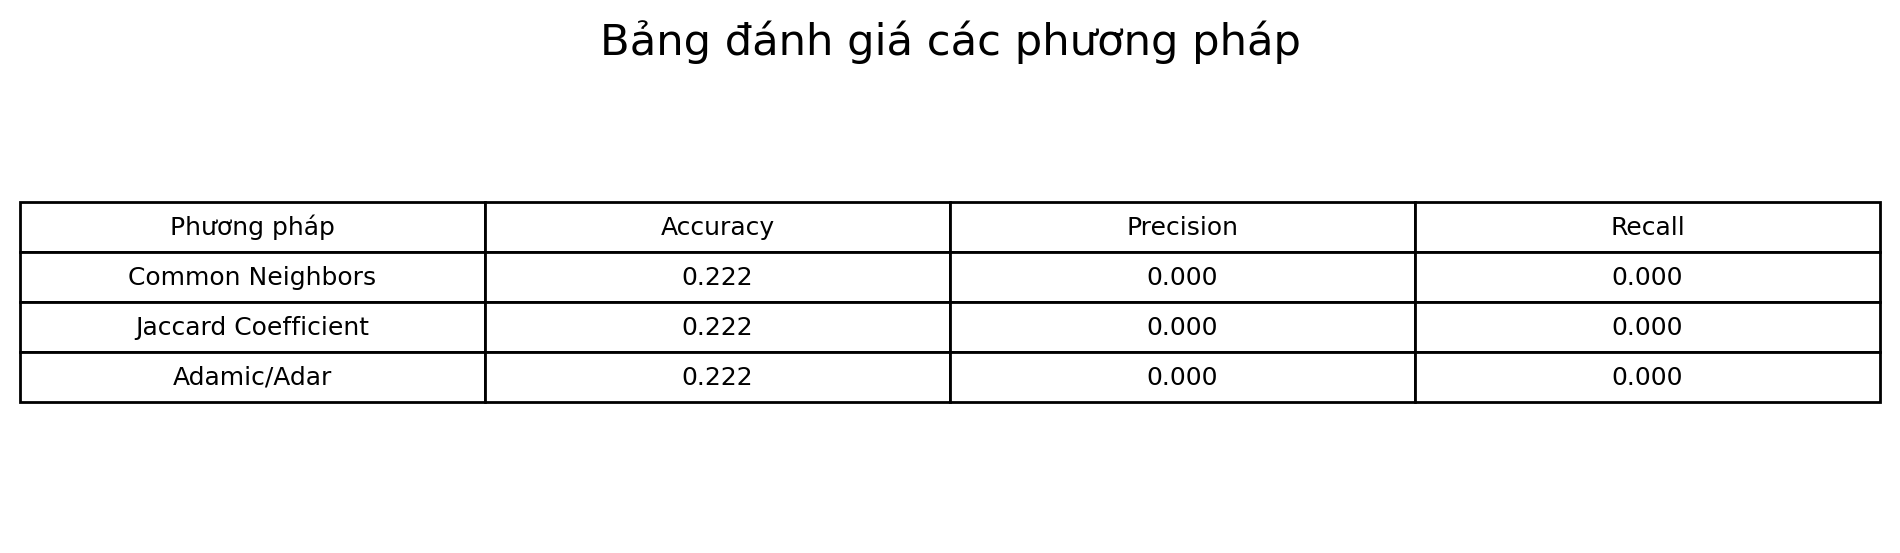

In [38]:
print("Chọn dataset:")
print("1. Zachary's Karate Club")
print("4. Les Miserables Network")

choice = input("Nhập lựa chọn (1-4): ")
dataset_map = {'1': 'karate', '2': 'davis', '3': 'florentine', '4': 'les'}

if choice in dataset_map:
    lp = LinkPrediction(dataset=dataset_map[choice])
    lp.run_experiment()
else:
    print("Lựa chọn không hợp lệ!")

## Test 3


In [39]:
import os
import zipfile
import requests
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

class GNNLinkPredictor(nn.Module):
    """Simple GNN for link prediction"""
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Linear(input_dim, 32)
        self.conv2 = nn.Linear(32, 16)
        self.predict = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return torch.sigmoid(self.predict(x))

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """Khởi tạo với dataset"""
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số lượng node: {self.G.number_of_nodes()}")
        print(f"Số lượng cạnh: {self.G.number_of_edges()}")
        print(f"Hệ số clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))

        # Vẽ cấu trúc mạng
        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8)
        plt.title("Cấu trúc mạng")

        # Vẽ phân phối bậc
        plt.subplot(132)
        degrees = [d for n, d in self.G.degree()]
        plt.hist(degrees, bins=max(degrees)-min(degrees)+1, edgecolor='black')
        plt.title("Phân phối bậc")
        plt.xlabel("Bậc")
        plt.ylabel("Số lượng node")

        # Vẽ phân phối clustering coefficient
        plt.subplot(133)
        clustering_coeffs = list(nx.clustering(self.G).values())
        plt.hist(clustering_coeffs, bins=10, edgecolor='black')
        plt.title("Phân phối hệ số clustering")
        plt.xlabel("Hệ số clustering")
        plt.ylabel("Số lượng node")

        plt.tight_layout()
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu và chia thành tập train/test."""
        # Copy đồ thị gốc
        self.original_G = self.G.copy()

        # Chia cạnh thành train/test
        all_edges = list(self.G.edges())
        train_edges, test_edges = train_test_split(all_edges, test_size=0.05, random_state=42)

        # Tạo đồ thị train
        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(test_edges)

        # Lấy các cặp node không có cạnh
        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        test_non_edges = non_edges[:len(test_edges)]

        # Lưu lại để sử dụng
        self.train_edges = train_edges
        self.test_edges = test_edges
        self.test_non_edges = test_non_edges

        print("\n=== Thông tin về tập dữ liệu ===")
        print(f"Tổng số cạnh ban đầu: {len(all_edges)}")
        print(f"Số cạnh train: {len(train_edges)}")
        print(f"Số cạnh test: {len(test_edges)}")
        print(f"Số cặp node test không có cạnh: {len(test_non_edges)}")

    def common_neighbors_score(self, u, v):
        """Tính điểm dựa trên số lượng láng giềng chung."""
        return len(list(nx.common_neighbors(self.train_G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """Tính hệ số Jaccard."""
        neighbors_u = set(self.train_G.neighbors(u))
        neighbors_v = set(self.train_G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """Tính chỉ số Adamic/Adar."""
        return sum(1 / np.log(self.train_G.degree(w))
                  for w in nx.common_neighbors(self.train_G, u, v))

    def resource_allocation_score(self, u, v):
        """Tính điểm Resource Allocation."""
        return sum(1 / self.train_G.degree(w)
                  for w in nx.common_neighbors(self.train_G, u, v))

    def katz_score(self, u, v, beta=0.1, max_length=3):
        """Tính điểm Katz index."""
        score = 0
        for path_length in range(1, max_length + 1):
            num_paths = len(list(nx.all_simple_paths(
                self.train_G, u, v, cutoff=path_length)))
            score += (beta ** path_length) * num_paths
        return score

    def prepare_deep_learning_features(self, edge_list):
        """Chuẩn bị đặc trưng cho deep learning."""
        features = []
        for u, v in edge_list:
            node_u = list(self.train_G.neighbors(u))
            node_v = list(self.train_G.neighbors(v))

            feat = [
                len(node_u),
                len(node_v),
                len(set(node_u) & set(node_v)),
                self.resource_allocation_score(u, v),
                self.katz_score(u, v)
            ]
            features.append(feat)
        return np.array(features)

    def visualize_prediction_validation(self, predictions, method_name):
        """Vẽ kết quả dự đoán."""
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(self.original_G, seed=42)

        # Vẽ đồ thị dự đoán
        plt.subplot(121)
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)

        test_pairs = self.test_edges + self.test_non_edges
        predicted_edges = [test_pairs[i] for i in range(len(predictions))
                         if predictions[i] == 1]

        correct_edges = [e for e in predicted_edges if e in self.test_edges]
        wrong_edges = [e for e in predicted_edges if e not in self.test_edges]

        nx.draw_networkx_edges(self.train_G, pos, edgelist=correct_edges,
                             edge_color='red', style='dashed', width=2)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=wrong_edges,
                             edge_color='yellow', style='dashed', width=2)
        plt.title(f"{method_name}\nXanh: Train, Đỏ: Dự đoán đúng, Vàng: Dự đoán sai")

        # Vẽ đồ thị thực tế
        plt.subplot(122)
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=self.test_edges,
                             edge_color='red', style='dashed', width=2)
        plt.title("Thực tế\nXanh: Train, Đỏ: Test")

        plt.tight_layout()
        plt.show()

    def train_gnn(self, X_train, y_train, X_test, y_test):
        """Huấn luyện mô hình GNN."""
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        X_test = torch.FloatTensor(X_test)

        model = GNNLinkPredictor(X_train.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters())

        epochs = 100
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            output = model(X_train).squeeze()
            loss = criterion(output, y_train)

            loss.backward()
            optimizer.step()

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            predictions = model(X_test).squeeze()
            predictions = (predictions > 0.5).numpy()

        return predictions

    def evaluate_methods(self):
        """Đánh giá các phương pháp dự đoán liên kết."""
        print("\n=== Đánh giá các phương pháp ===")

        test_edges = self.test_edges + self.test_non_edges
        y_test = np.hstack([np.ones(len(self.test_edges)),
                           np.zeros(len(self.test_non_edges))])

        methods = [
            ('Common Neighbors', self.common_neighbors_score),
            ('Jaccard', self.jaccard_coefficient_score),
            ('Adamic/Adar', self.adamic_adar_score),
            ('Resource Allocation', self.resource_allocation_score),
            ('Katz Index', self.katz_score)
        ]

        results = []

        for method_name, score_func in methods:
            scores = [score_func(u, v) for u, v in test_edges]
            threshold = np.percentile(scores, 70)
            predictions = (np.array(scores) > threshold).astype(int)

            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': method_name,
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            self.visualize_prediction_validation(predictions, method_name)

        print("\nHuấn luyện mô hình Deep Learning...")
        X = self.prepare_deep_learning_features(test_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y_test, test_size=0.2)

        dl_predictions = self.train_gnn(X_train, y_train, X_test, y_test)

        acc = accuracy_score(y_test, dl_predictions)
        prec = precision_score(y_test, dl_predictions)
        rec = recall_score(y_test, dl_predictions)

        results.append({
            'Phương pháp': 'Deep Learning',
            'Accuracy': f"{acc:.3f}",
            'Precision': f"{prec:.3f}",
            'Recall': f"{rec:.3f}"
        })

        df_results = pd.DataFrame(results)
        plt.figure(figsize=(12, 3))
        plt.axis('off')
        table = plt.table(cellText=df_results.values,
                         colLabels=df_results.columns,
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('So sánh các phương pháp dự đoán liên kết')
        plt.show()

    def run_experiment(self):
        """Chạy toàn bộ thử nghiệm."""
        print("=== Bắt đầu thử nghiệm ===")
        self.analyze_network()
        self.prepare_data()
        self.evaluate_methods()

Chọn dataset:
1. Zachary's Karate Club
2. Davis Southern Women
3. Florentine Families
4. Les
5. Political Blogs Network
=== Bắt đầu thử nghiệm ===

=== Phân tích mạng ===
Số lượng node: 34
Số lượng cạnh: 78
Hệ số clustering trung bình: 0.571


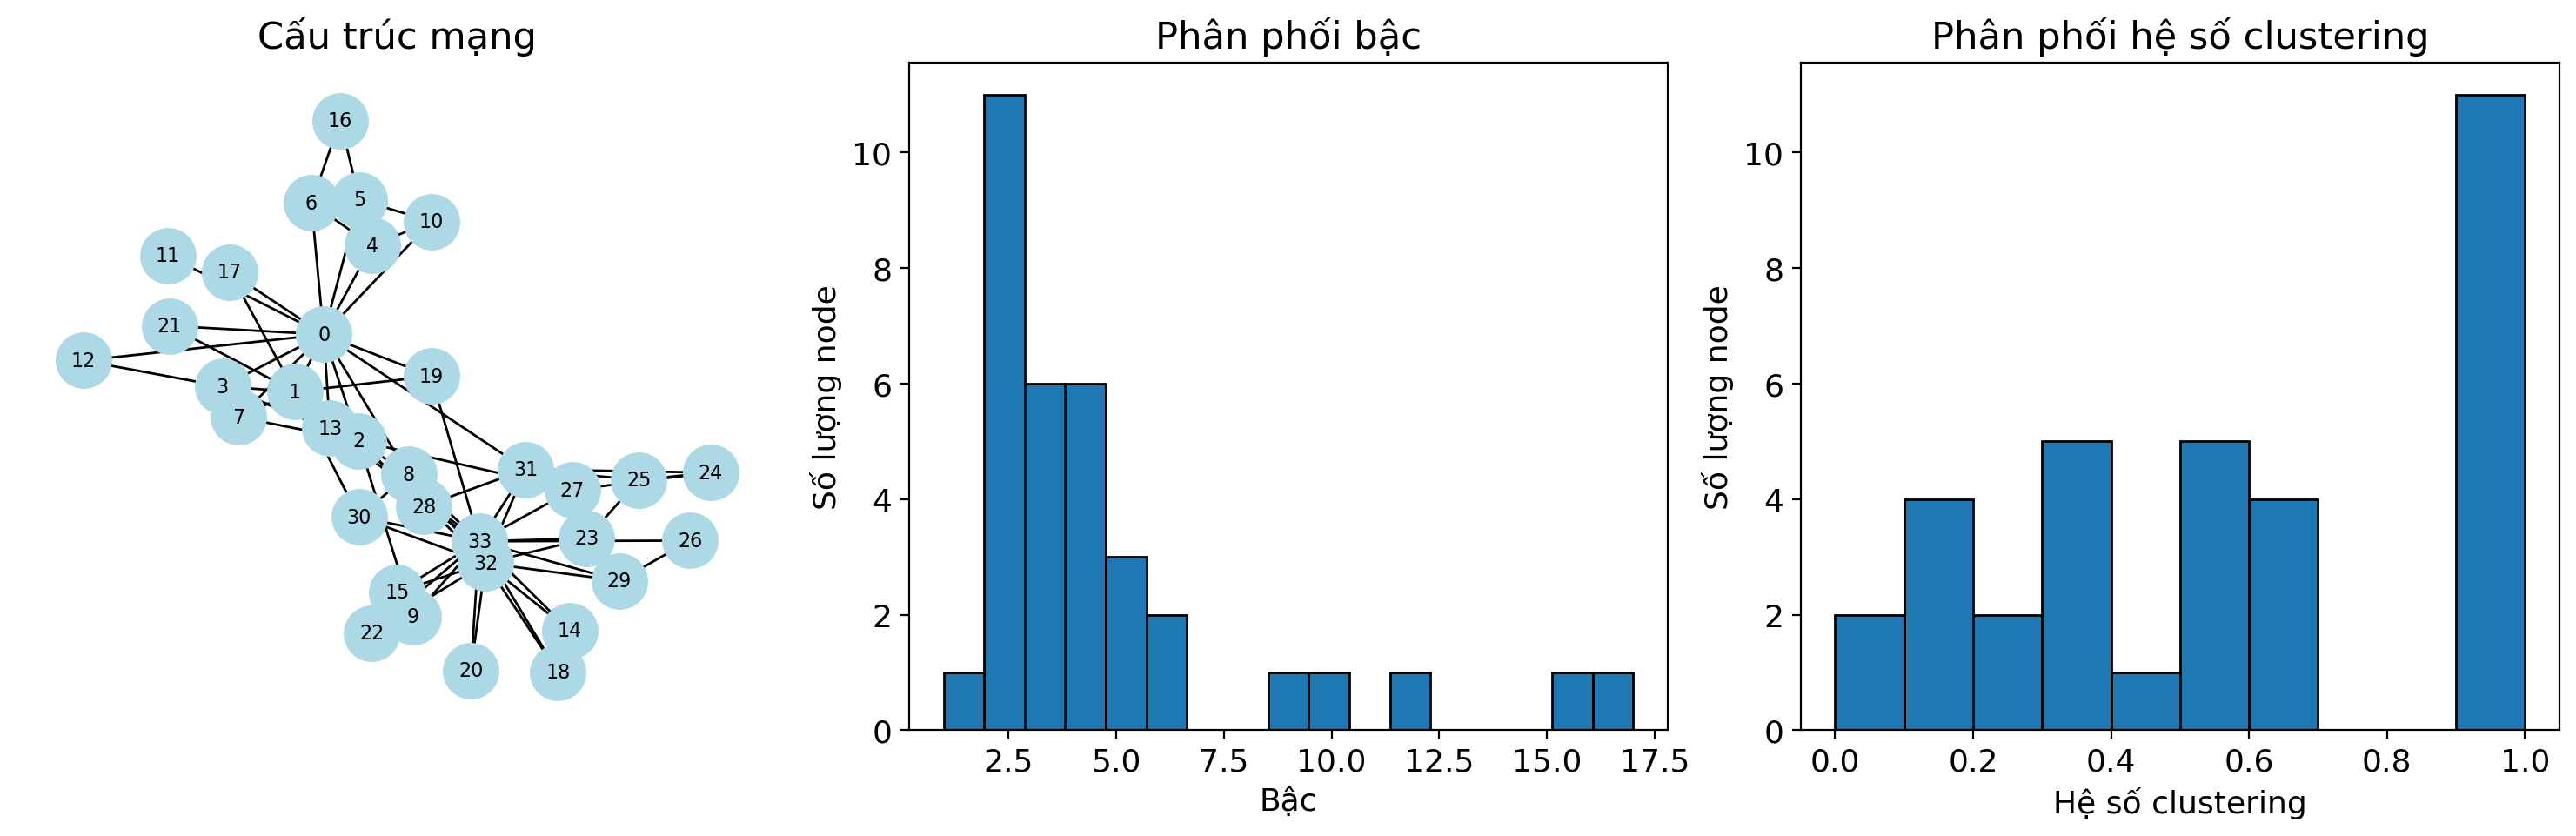


=== Thông tin về tập dữ liệu ===
Tổng số cạnh ban đầu: 78
Số cạnh train: 74
Số cạnh test: 4
Số cặp node test không có cạnh: 4

=== Đánh giá các phương pháp ===


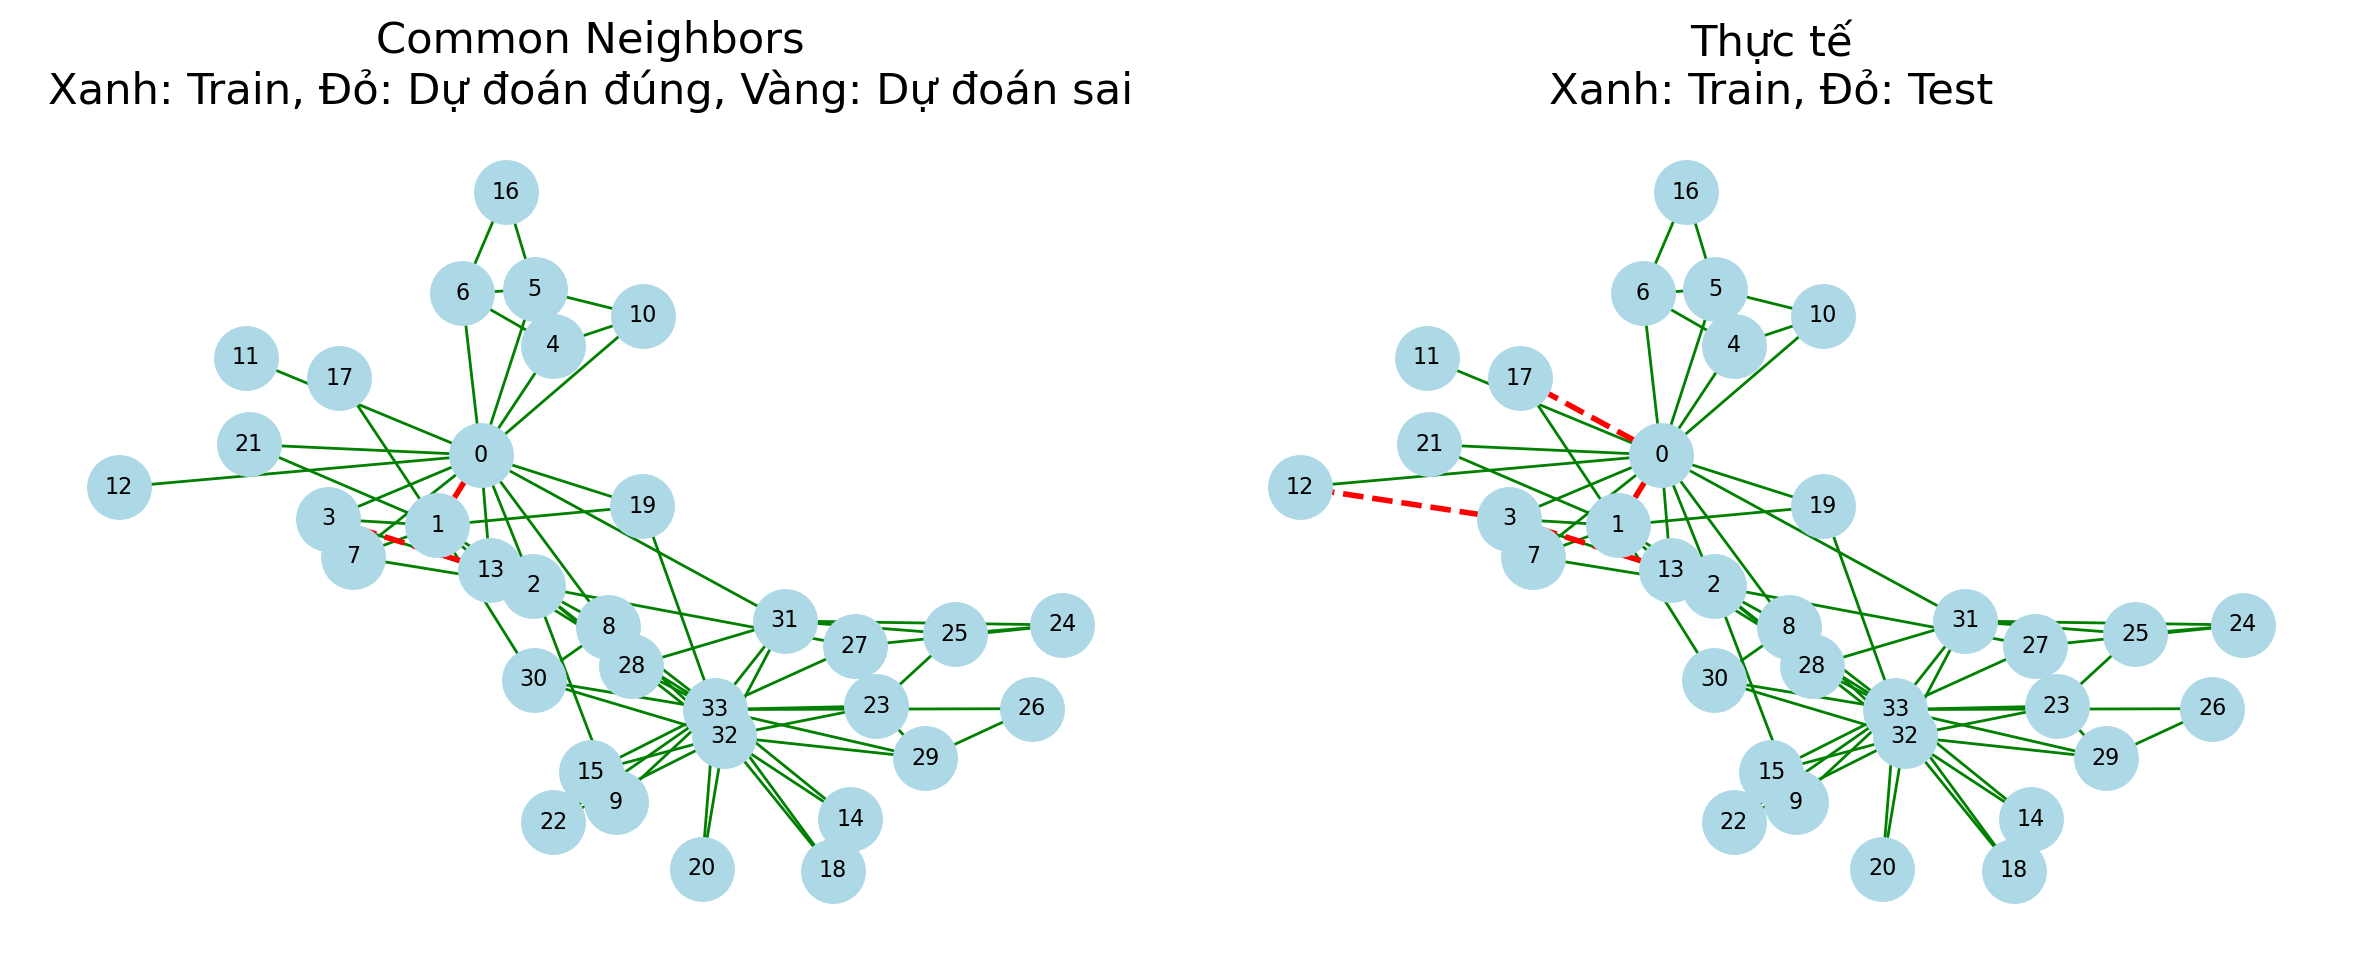

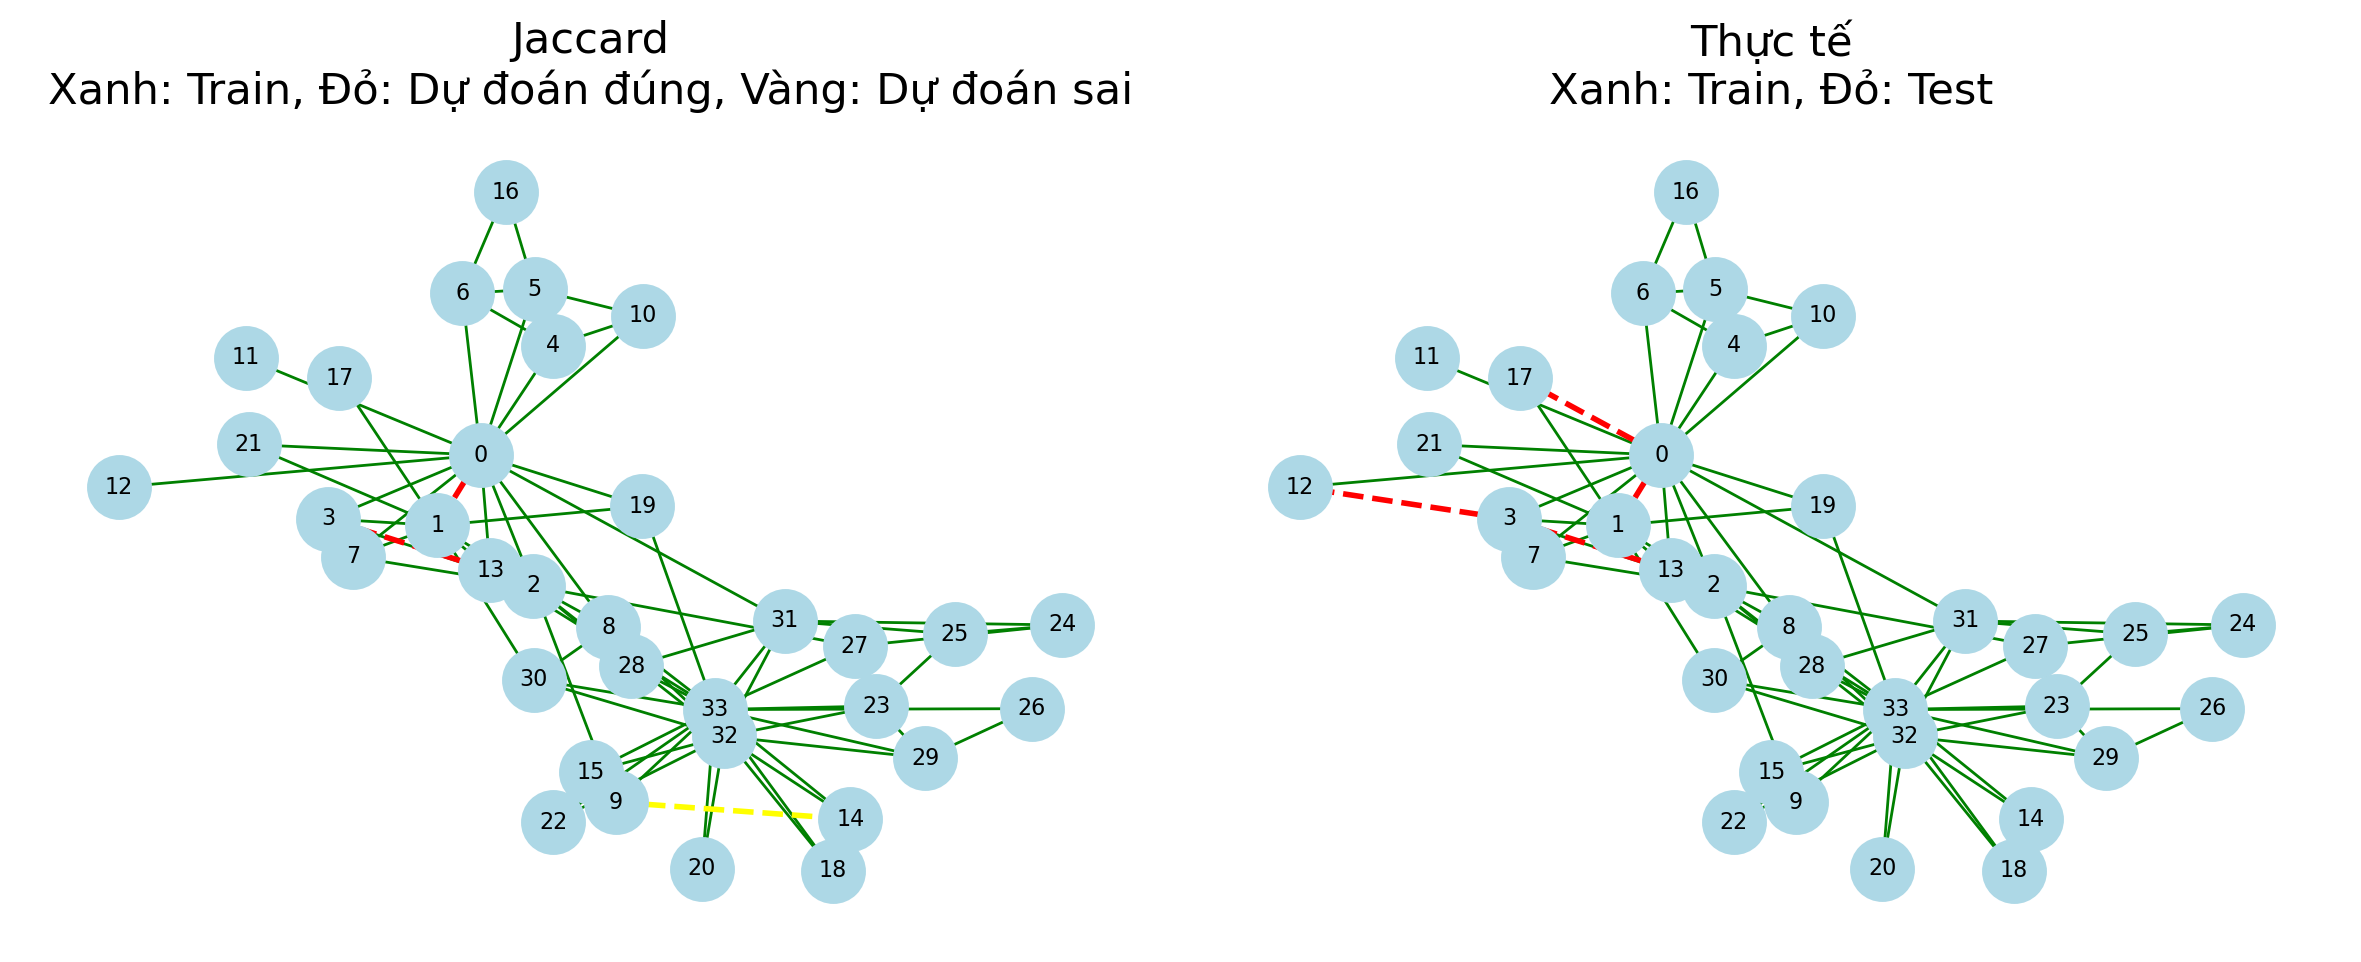

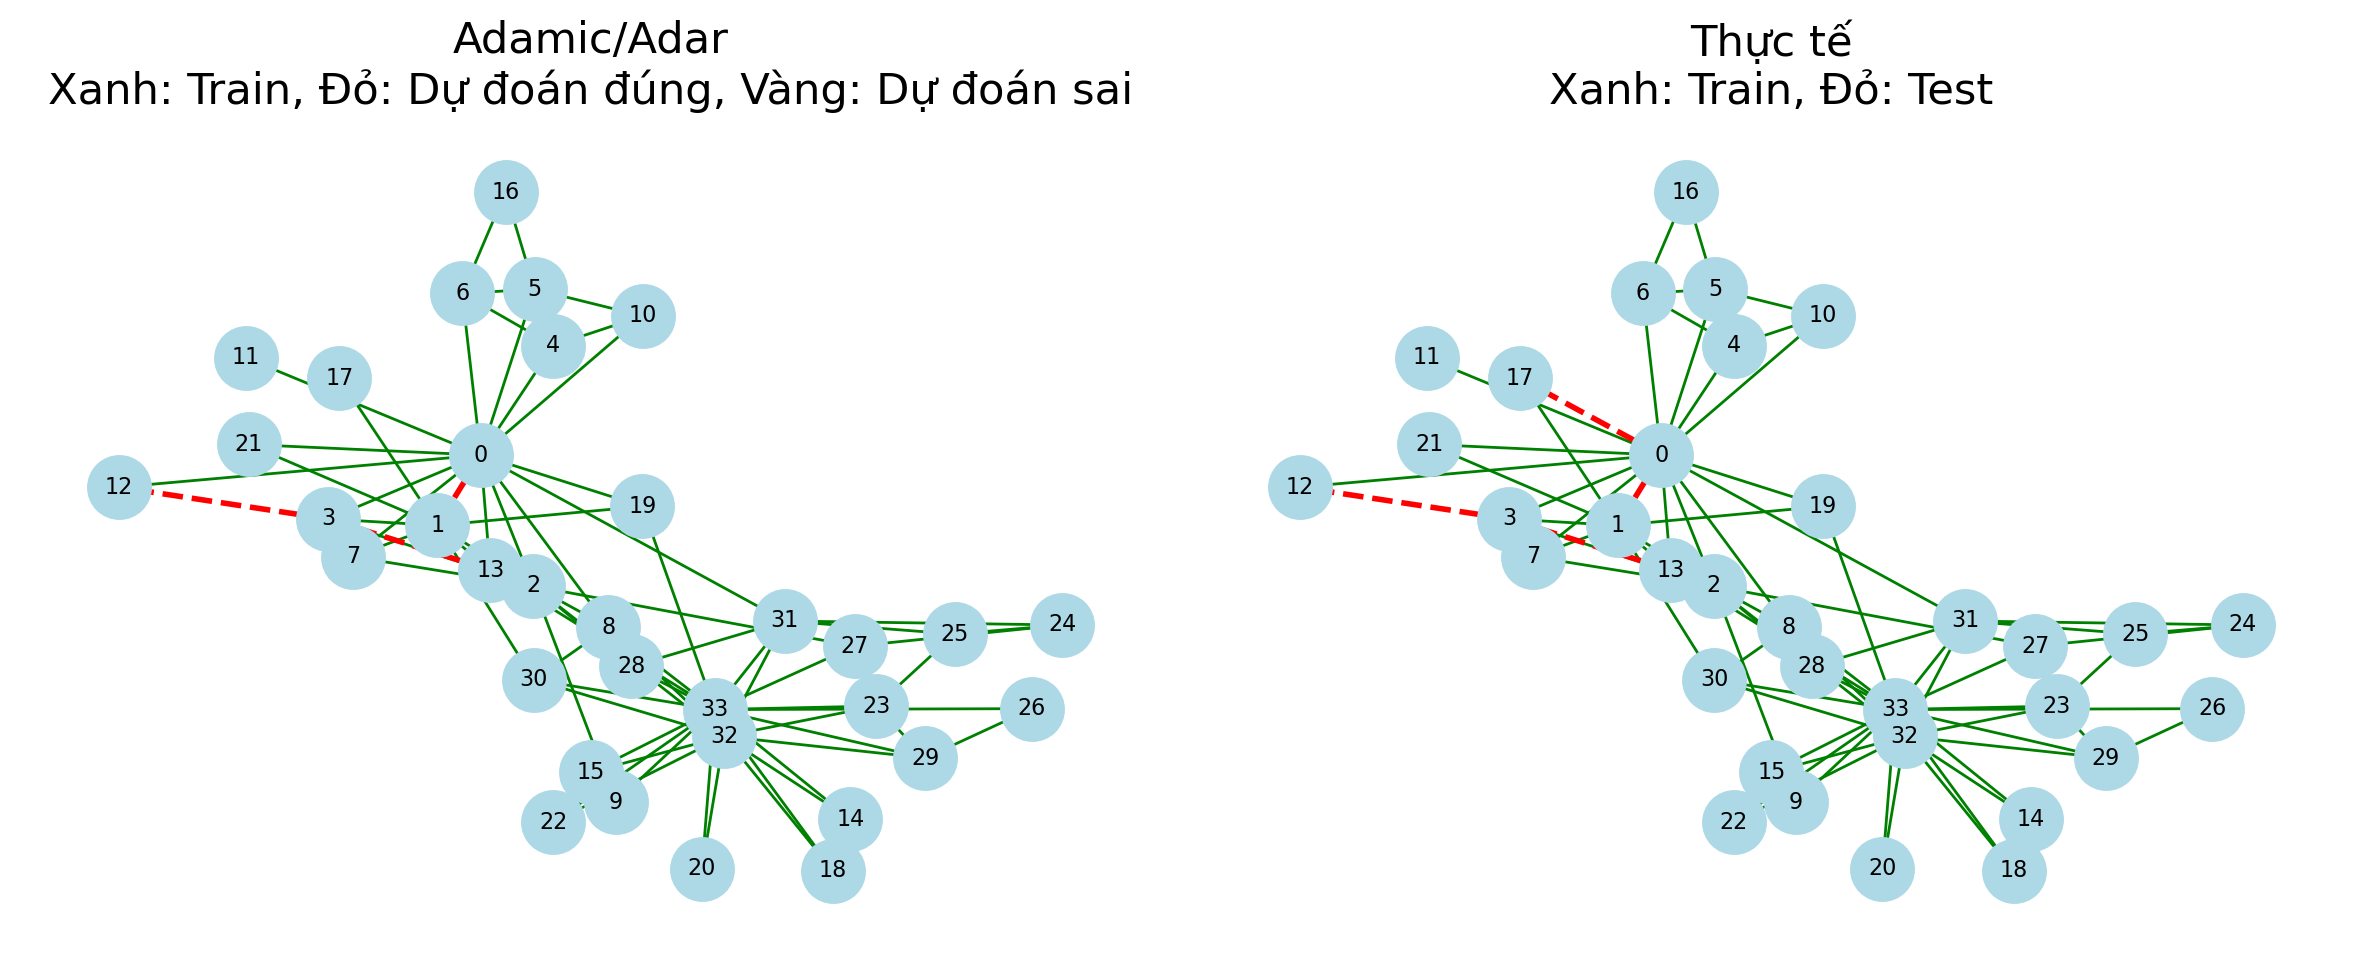

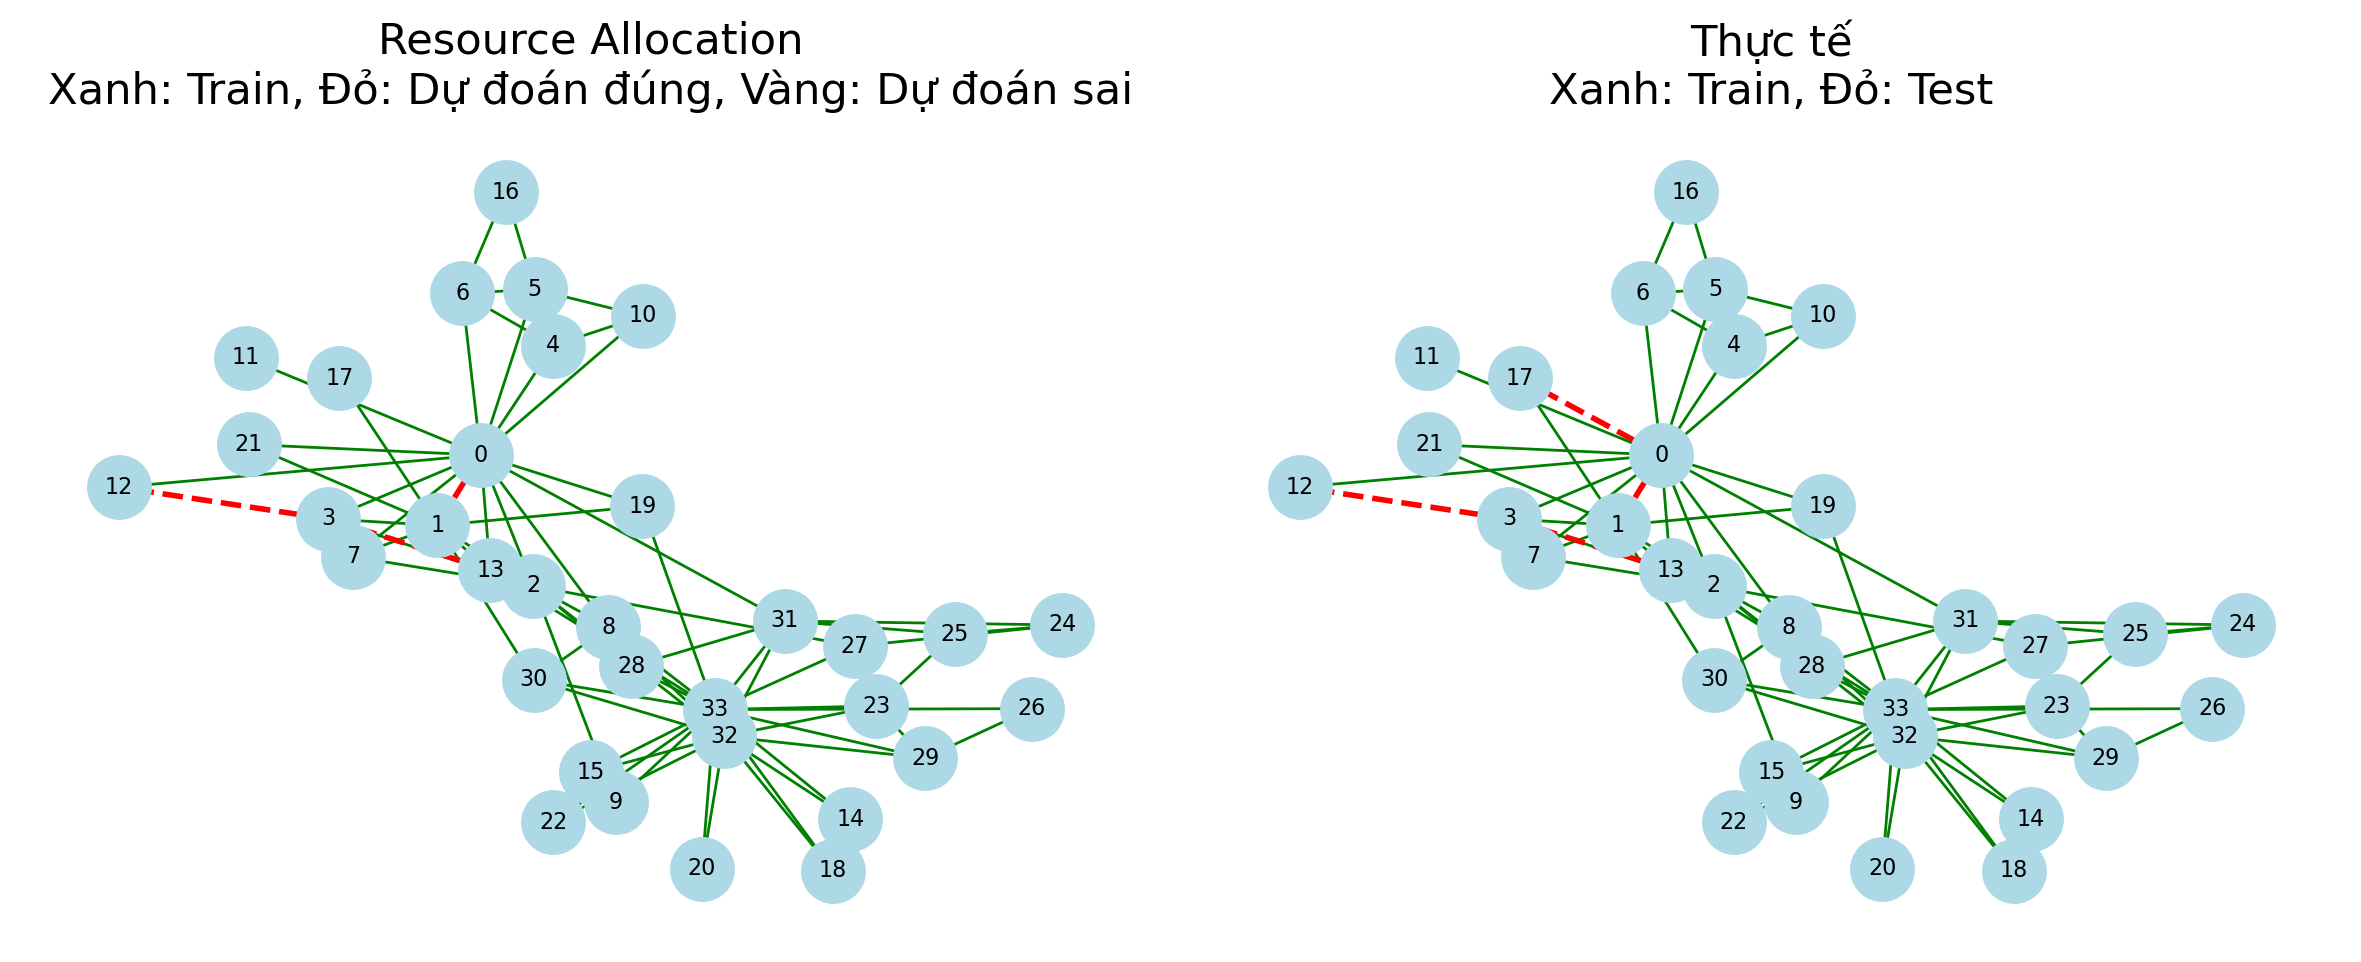

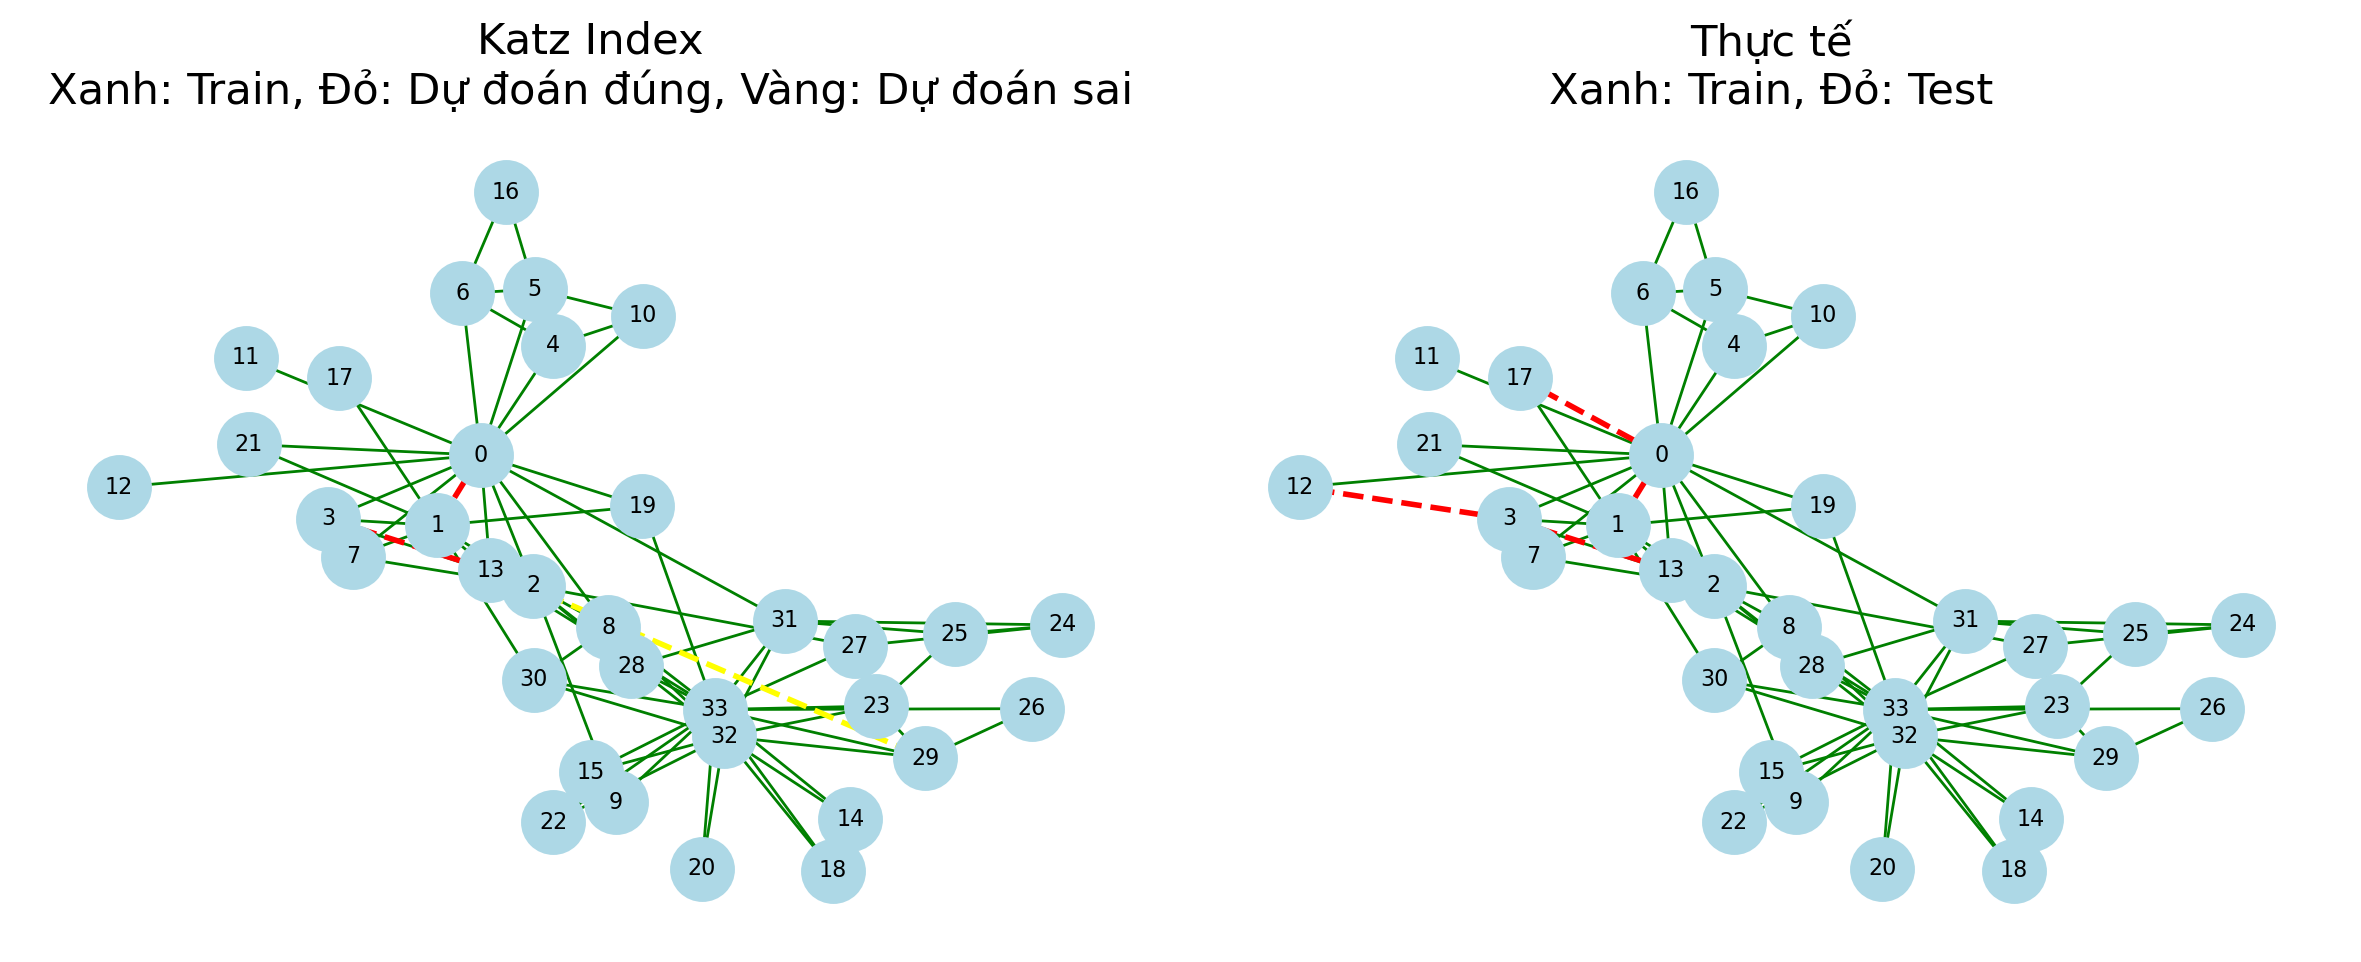


Huấn luyện mô hình Deep Learning...
Epoch [20/100], Loss: 0.5990
Epoch [40/100], Loss: 0.5446
Epoch [60/100], Loss: 0.4684
Epoch [80/100], Loss: 0.3790
Epoch [100/100], Loss: 0.2855


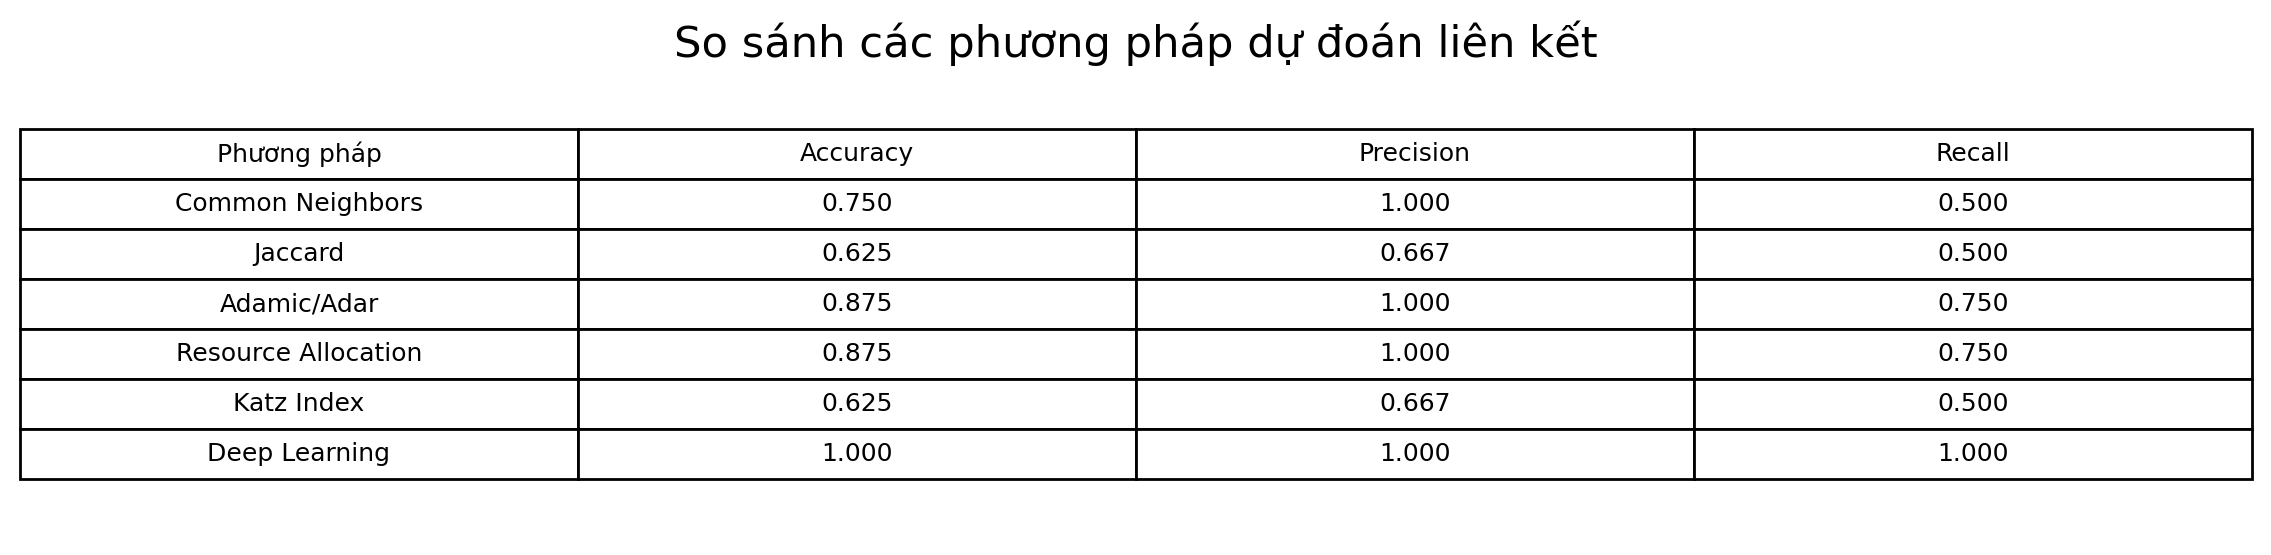

In [41]:
def main():
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Davis Southern Women")
    print("3. Florentine Families")
    print("4. Les")
    # Political Blogs Network
    print("5. Political Blogs Network")

    choice = input("Nhập lựa chọn (1-3): ")
    #dataset_map = {'1': 'karate', '2': 'davis', '3': 'florentine', '4': 'les'}
    dataset_map = {'1': 'karate', '2': 'davis', '3': 'florentine', '4': 'les', '5': 'polblogs'}

    if choice in dataset_map:
        lp = LinkPrediction(dataset=dataset_map[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")

if __name__ == "__main__":
    main()